In [1]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara
-- exclude non-standard CCG codes:
WHERE SUBSTR(pct,1,1) NOT BETWEEN 'A' AND 'Z' -- first character numerical
AND SUBSTR(pct,3,1) BETWEEN 'A' AND 'Z'  -- last character alphabetical
'''

df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard',verbose=False)

## Clean the data: sort out null denominators

In [63]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
data2


pct  subpara  denom_subpara   chemical    num    denom     ratio
727     10C  0402010         2306.0  0402010P0    0.0      0.0  0.000000
2238    10D  0402010         4034.0  0402010P0    0.0      0.0  0.000000
3749    10E  0402010         6924.0  0402010P0    0.0      0.0  0.000000
5260    10G  0402010         2448.0  0402010P0    4.0   2448.0  0.001634
6771    10H  0402010         8066.0  0402010P0    0.0      0.0  0.000000
8282    10J  0402010        11448.0  0402010P0   20.0  11448.0  0.001747
9793    10K  0402010         9902.0  0402010P0    1.0   9902.0  0.000101
11304   10L  0402010         8251.0  0402010P0    2.0   8251.0  0.000242
12815   10M  0402010         3552.0  0402010P0    0.0      0.0  0.000000
14326   10N  0402010         3909.0  0402010P0    0.0      0.0  0.000000
15837   10Q  0402010        22914.0  0402010P0    1.0  22914.0  0.000044
17348   10R  0402010        12974.0  0402010P0    4.0  12974.0  0.000308
18859   10T  0402010         7823.0  0402010P0    0.0      0.0  0.000000
20370   10V  0402010         8755.0  0402010P0   10.0   8755.0  0.001142
21881   10W  0402010         4997.0  0402010P0    0.0      0.0  0.000000
23392   10X  0402010        14918.0  0402010P0    0.0      0.0  0.000000
24903   10Y  0402010         6116.0  0402010P0    3.0   6116.0  0.000491
26414   11A  0402010        19885.0  0402010P0   58.0  19885.0  0.002917
27925   11C  0402010         4308.0  0402010P0    0.0      0.0  0.000000
29436   11D  0402010         3652.0  0402010P0    2.0   3652.0  0.000548
30947   11E  0402010         8726.0  0402010P0    0.0      0.0  0.000000
32458   11H  0402010        24271.0  0402010P0    3.0  24271.0  0.000124
33969   11J  0402010        27916.0  0402010P0    6.0  27916.0  0.000215
35480   11M  0402010        31036.0  0402010P0   51.0  31036.0  0.001643
36991   11N  0402010        21999.0  0402010P0  122.0  21999.0  0.005546
38502   11T  0402010        10983.0  0402010P0    0.0      0.0  0.000000
40013   11X  0402010        19322.0  0402010P0   46.0  19322.0  0.002381
41524   12A  0402010         6125.0  0402010P0    5.0   6125.0  0.000816
43035   12D  0402010        10404.0  0402010P0    0.0      0.0  0.000000
44546   12F  0402010        17695.0  0402010P0   20.0  17695.0  0.001130
...     ...      ...            ...        ...    ...      ...       ...
268174  08G  0402010        10235.0  0402010P0    0.0      0.0  0.000000
269685  08H  0402010         8915.0  0402010P0    2.0   8915.0  0.000224
271196  08J  0402010         6668.0  0402010P0    1.0   6668.0  0.000150
272707  08K  0402010        16285.0  0402010P0   25.0  16285.0  0.001535
274218  08L  0402010         8931.0  0402010P0    4.0   8931.0  0.000448
275729  08M  0402010        17858.0  0402010P0   56.0  17858.0  0.003136
277240  08N  0402010         8498.0  0402010P0    4.0   8498.0  0.000471
278751  08P  0402010         8177.0  0402010P0    4.0   8177.0  0.000489
280262  08Q  0402010        10992.0  0402010P0   12.0  10992.0  0.001092
281773  08R  0402010         7401.0  0402010P0    4.0   7401.0  0.000540
283284  08T  0402010         9114.0  0402010P0    0.0      0.0  0.000000
284795  08V  0402010        24323.0  0402010P0    0.0      0.0  0.000000
286306  08W  0402010        11285.0  0402010P0    0.0      0.0  0.000000
287817  08X  0402010        15165.0  0402010P0    3.0  15165.0  0.000198
289328  08Y  0402010         8697.0  0402010P0    0.0      0.0  0.000000
290839  09A  0402010         9078.0  0402010P0    0.0      0.0  0.000000
292350  09C  0402010         3559.0  0402010P0    2.0   3559.0  0.000562
293861  09D  0402010        24166.0  0402010P0    1.0  24166.0  0.000041
295372  09E  0402010         6611.0  0402010P0    7.0   6611.0  0.001059
296883  09F  0402010        10508.0  0402010P0   23.0  10508.0  0.002189
298394  09G  0402010        22741.0  0402010P0   15.0  22741.0  0.000660
299905  09H  0402010         3938.0  0402010P0    6.0   3938.0  0.001524
301416  09J  0402010         9731.0  0402010P0    6.0   9731.0  0.

### Filter out low numbers (chemical and subpara)

In [78]:
# total prescribing for each chemical
#sum numerators to find total volume for each chemical
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))
num.head()

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.merge(num, how="inner", on="chemical",suffixes=("","_total"))
data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))


data3 = data3.loc[(data3["denom centile"]>2) & (data3["num centile"]>2)]

# num of CCGs prescribing each chemical
count_ = pd.DataFrame(data3.loc[data3["num"]>0].groupby("chemical")["pct"].nunique()).reset_index()
count_ = count_.rename(columns={"pct":"count2"})

data3 = data3.merge(count_, how="inner", on="chemical")

count_.loc[count_["chemical"]=="0402010P0"] # pericyazine

pct  subpara  denom_subpara   chemical    num   denom     ratio  \
0       10C  1202030          203.0  1202030R0   35.0   203.0  0.172414   
1       10D  1202030          210.0  1202030R0   23.0   210.0  0.109524   
2       10E  1202030          216.0  1202030R0   27.0   216.0  0.125000   
3       10G  1202030          320.0  1202030R0   32.0   320.0  0.100000   
4       10H  1202030          753.0  1202030R0  144.0   753.0  0.191235   
5       10J  1202030          497.0  1202030R0   96.0   497.0  0.193159   
6       10K  1202030          338.0  1202030R0   56.0   338.0  0.165680   
7       10L  1202030          177.0  1202030R0   42.0   177.0  0.237288   
8       10M  1202030          184.0  1202030R0   23.0   184.0  0.125000   
9       10N  1202030          164.0  1202030R0   17.0   164.0  0.103659   
10      10Q  1202030         1112.0  1202030R0  126.0  1112.0  0.113309   
11      10R  1202030          373.0  1202030R0   77.0   373.0  0.206434   
12      10T  1202030          456.0  1202030R0   45.0   456.0  0.098684   
13      10V  1202030          424.0  1202030R0   73.0   424.0  0.172170   
14      10W  1202030          205.0  1202030R0   38.0   205.0  0.185366   
15      10X  1202030          423.0  1202030R0   59.0   423.0  0.139480   
16      10Y  1202030          431.0  1202030R0   70.0   431.0  0.162413   
17      11A  1202030         1152.0  1202030R0  266.0  1152.0  0.230903   
18      11C  1202030          332.0  1202030R0   37.0   332.0  0.111446   
19      11D  1202030          273.0  1202030R0   46.0   273.0  0.168498   
20      11E  1202030          285.0  1202030R0   65.0   285.0  0.228070   
21      11H  1202030          873.0  1202030R0  222.0   873.0  0.254296   
22      11J  1202030         1617.0  1202030R0  292.0  1617.0  0.180581   
23      11M  1202030         1114.0  1202030R0  234.0  1114.0  0.210054   
24      11N  1202030         1078.0  1202030R0  199.0  1078.0  0.184601   
25      11T  1202030          456.0  1202030R0   96.0   456.0  0.210526   
26      11X  1202030         1182.0  1202030R0  247.0  1182.0  0.208968   
27      12A  1202030          541.0  1202030R0  131.0   541.0  0.242144   
28      12D  1202030          373.0  1202030R0   59.0   373.0  0.158177   
29      12F  1202030          777.0  1202030R0  205.0   777.0  0.263835   
...     ...      ...            ...        ...    ...     ...       ...   
230020  09A  1301010          477.0  1301010D0  476.0   477.0  0.997904   
230021  09Y  1301010           74.0  1301010D0   72.0    74.0  0.972973   
230022  11A  1301010          253.0  1301010I0    1.0   253.0  0.003953   
230023  11J  1301010          865.0  1301010I0    2.0   865.0  0.002312   
230024  11M  1301010          104.0  1301010I0    0.0     0.0  0.000000   
230025  99N  1301010         1076.0  1301010I0    3.0  1076.0  0.002788   
230026  01K  1301010           52.0  1301010I0    0.0     0.0  0.000000   
230027  03C  1301010           83.0  1301010I0   77.0    83.0  0.927711   
230028  03F  1301010           53.0  1301010I0   25.0    53.0  0.471698   
230029  03G  1301010           60.0  1301010I0   60.0    60.0  1.000000   
230030  03H  1301010           96.0  1301010I0    1.0    96.0  0.010417   
230031  04C  1301010           66.0  1301010I0    5.0    66.0  0.075758   
230032  05G  1301010           72.0  1301010I0   31.0    72.0  0.430556   
230033  06H  1301010           67.0  1301010I0    1.0    67.0  0.014925   
230034  06N  1301010           79.0  1301010I0    1.0    79.0  0.012658   
230035  07M  1301010          202.0  1301010I0    1.0   202.0  0.004950   
230036  07P  1301010         2429.0  1301010I0    2.0  2429.0  0.000823   
230037  07R  1301010           64.0  1301010I0    0.0     0.0  0.000000   
230038  07T  1301010           80.0  1301010I0   25.0    80.0  0.312500   
230039  07W  1301010         3857.0  1301010I0    4.0  3857.0  0.001037   
230040  07Y  1301010         2022.0  1301010I0    1.0  2022.0  0.000495   
230041  08C  1301010          551

## Calculate key stats
### Median, Range, SD, Kurtosis and Skew

In [75]:
#select columns of interest and get key stats
df2 = pd.DataFrame(data3.groupby(["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count2"])["ratio"].describe())
df2 = df2.unstack()
df2.columns = df2.columns.droplevel()

df3 = df2.reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count","count2","50%","min","max","range","std"]].rename(columns={"50%":"median"})

# filter out chemicals in paragraphs only prescribed by few CCGs
df3 = df3.loc[df3["count"]>=50]


# reshape data to put CCGs in columns
df5 = data3.pivot(index="chemical",columns='pct', values='ratio')

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")

# compile all stats together
result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result[["chemical","subpara", "count","count2","num_total","num centile","median","min","max","range","std","kurtosis","skew"]].round(2)

# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
df4 = df4[["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"]].round(2)

df4.loc[df4["chemical name"]=="Pericyazine"]#head()

chemical chemical name  subpara         subpara name  num_total  \
239  0402010P0   Pericyazine  0402010  Antipsychotic Drugs    15346.0   

     num centile  count  count2  median  min   max  range   std  kurtosis  \
239          7.0  207.0   155.0     0.0  0.0  0.24   0.24  0.03      49.6   

     skew  
239  6.99

## Ranking Chemicals by Range, Kurtosis, Skew and SD
Those with high range and SD tend to be chemicals where there is general disagreement, so outliers are not *that* unusual

In [76]:
# limit to those with positive skew, i.e. most CCGs prescribe few and those prescribing more are ouliers,
# and range at least 10%:
dfp = df4.loc[(df4["skew"]>=0) & (df4["range"]>0.1)]


# sort by range
r1 = dfp.sort_values(by=["range","kurtosis"],ascending=False)
# create a ranking
r1["R"]  = -np.log(r1["range"].rank(pct=True,ascending=False, method="min"))

# sort by kurtosis 
r2 = dfp.sort_values(by=["kurtosis"],ascending=False)
r2["K"] = -np.log(r2["kurtosis"].rank(pct=True,ascending=False, method="min"))

# sort by skew
r3 = dfp.sort_values(by=["skew"],ascending=False)
r3["Sk"] = -np.log(r3["skew"].rank(pct=True,ascending=False, method="min"))

#sort by SD
#r4 = dfp.sort_values(by=["std"],ascending=False)
#r4["SD"] = 1

r2.sort_values(by="kurtosis",ascending=False).head(20)

chemical                          chemical name  subpara  \
70   1310011AA                            Retapamulin  1310011   
94   090602700         Other Vitamin B Compound Preps  0906027   
114  0601021X0                            Tolbutamide  0601021   
155  0206040AF             Nicotinic Acid Derivatives  0206040   
177  0902011L0          Calcium Polystyrene Sulfonate  0902011   
180  0501021B0                             Cefadroxil  0501021   
192  0101010F0                    Magnesium Carbonate  0101010   
196  0504010L0               Mefloquine Hydrochloride  0504010   
205  0501120X0                           Levofloxacin  0501120   
222  0905013N0                      Magnesium Sulfate  0905013   
232  1305020R0                             Tacalcitol  1305020   
239  0402010P0                            Pericyazine  0402010   
247  090603100  Other Vitamin C (Ascorbic Acid) Preps  0906031   
259  1105000S0                            Tropicamide  1105000   
261  1302020B0                  Benzalkonium Chloride  1302020   
268  0402010S0                Promazine Hydrochloride  0402010   
279  0501070N0                        Sodium Fusidate  0501070   
294  0904010K0                                Glucose  0904010   
295  1502010C0              Bupivacaine Hydrochloride  1502010   
317  090601100          Other Vitamin A Preps 0906011  0906011   

                                subpara name  num_total  num centile  count  \
70   Antibacterial Preps Only Used Topically      622.0          4.0  189.0   
94                        Vitamin B Compound     1070.0          4.0  207.0   
114                            Sulfonylureas     7666.0          6.0  207.0   
155  Peripheral Vasodilators & Related Drugs       70.0          3.0  185.0   
177                           Oral Potassium      561.0          4.0  192.0   
180                           Cephalosporins     1107.0          4.0  207.0   
192                  Antacids and Simeticone      119.0          3.0  192.0   
196                            Antimalarials     4625.0          5.0  207.0   
205                               Quinolones     4637.0          6.0  207.0   
222                                Magnesium      108.0          3.0  156.0   
232               Preparations For Psoriasis     1494.0          5.0  207.0   
239                      Antipsychotic Drugs    15346.0          7.0  207.0   
247                Vitamin C (Ascorbic Acid)       86.0          3.0  185.0   
259              Mydriatics And Cycloplegics      368.0          3.0  160.0   
261                     Barrier Preparations     4390.0          5.0  207.0   
268                      Antipsychotic Drugs    27754.0          7.0  207.0   
279                Some Other Antibacterials      783.0          4.0  169.0   
294                  Foods For Special Diets    12027.0          7.0  207.0   
295                       Local Anaesthetics     4042.0          5.0  207.0   
317                                Vitamin A      226.0          3.0  149.0   

     count2  median  min   max  range   std  kurtosis   skew         K  
70     25.0    0.00  0.0  0.68   0.68  0.05    157.67  12.36  6.021023  
94    116.0    0.00  0.0  0.17   0.17  0.01    126.43  10.67  5.327876  
114   187.0    0.00  0.0  0.12   0.12  0.01    110.49   9.49  4.922411  
155    24.0    0.00  0.0  0.13   0.13  0.01     88.27   8.85  4.634729  
177   118.0    0.01  0.0  0.43   0.43  0.04     74.50   7.47  4.411585  
180    96.0    0.00  0.0  0.25   0.25  0.02     71.29   7.41  4.229264  
192    25.0    0.00  0.0  0.19   0.19  0.02     66.74   7.53  4.075113  
196    89.0    0.00  0.0  0.32   0.32  0.04     64.92   8.15  3.941582  
205   201.0    0.02  0.0  0.37   0.37  0.03     61.48   6.32  3.823799  
222    33.0    0.00  0.0  0.21   0.21  0.02     55.03   6.61  3.718438  
232   176.0    0.00  0.0  0.12   0.12  0.01     52.93   7.01  3.623128  
239   155.0    0.00  0.0  0.24   0.24  0.03     49.60   6.99  3.536117  
247    25.

### Results compiled and with Hyperlinks to maps

In [47]:
# compile top 20 from each sort into a single output

rc = pd.merge(r1, r2, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"], how="outer").fillna(0) 
rc = rc.merge(r3, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"], how="outer")
#rc = rc.merge(r4, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer").fillna(0)  

rc["score"] = (2*rc["K"]+rc["Sk"]+rc["R"]) #+rc["SD"]
rc = rc.sort_values(by=["score","kurtosis"],ascending=False)


links = rc.head(50)
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)
#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

C:\Users\hcurtis\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hcurtis\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Histograms

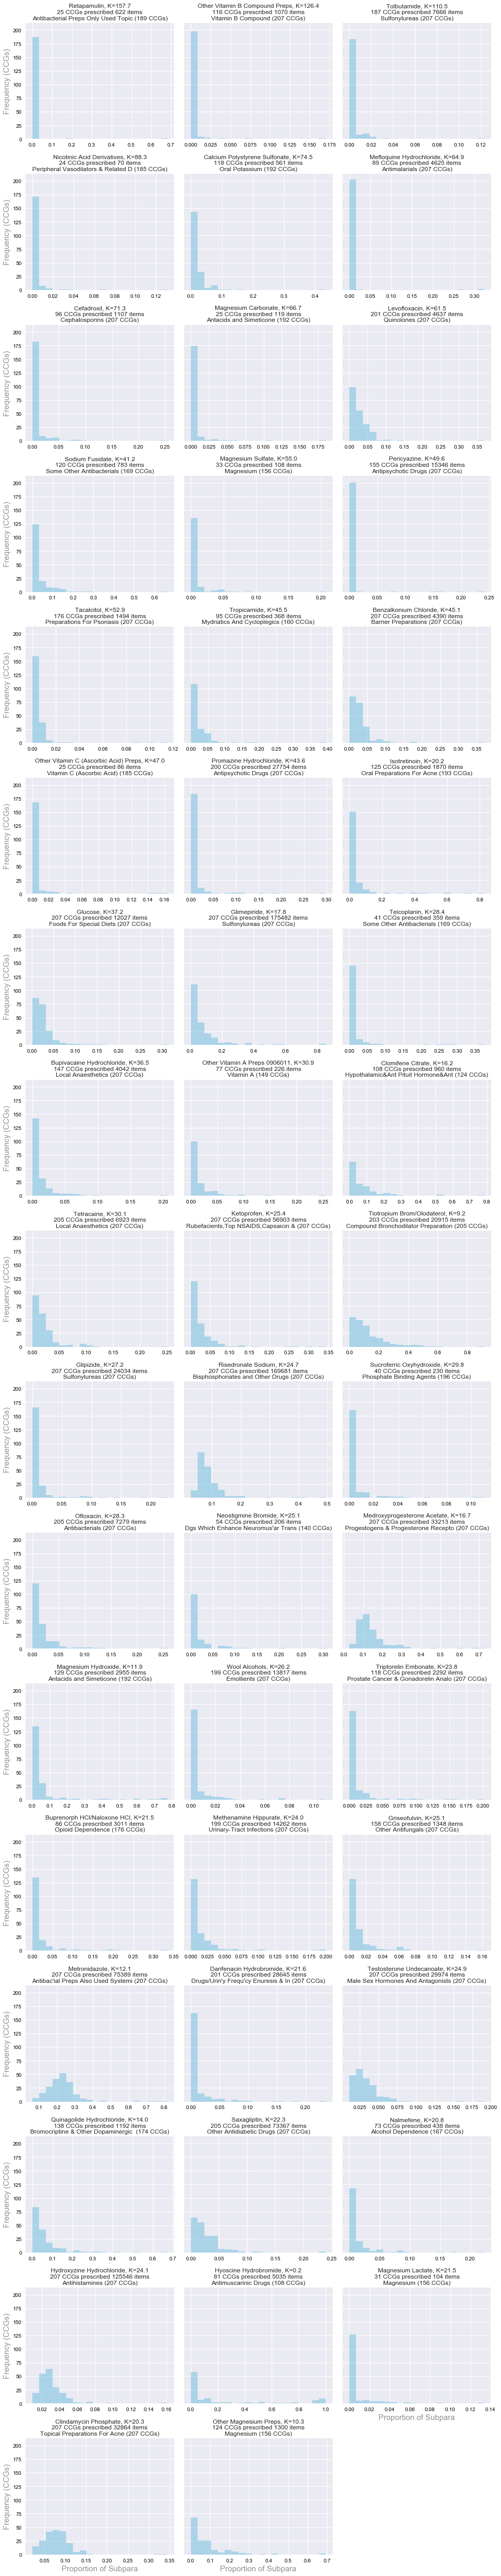

In [7]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name","count","count2","score","kurtosis","num_total"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","count","count2","num_total"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+", K="+titles["kurtosis"].round(1).map(str)+"\n"+titles["count2"].map(int).map(str)+" CCGs prescribed "+titles["num_total"].map(int).map(str)+" items\n"+titles["subpara name"].str[0:35]+" ("+titles["count"].map(int).map(str)+" CCGs)"

titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Percentile differences / IQR etc.
First Calculate various percentiles

In [8]:
dftest = df5.transpose()
q = [0.03,0.05,0.25,0.5,0.75,0.95,0.97]
smy0 = dftest.describe(percentiles=q).drop(["count","mean","std"]).transpose()

#calculate IQR
smy0["IQR"] = smy0["75%"]-smy0["25%"] 

smy0.head()

min        3%       5%       25%       50%       75%  \
chemical                                                               
0101010C0  0.000000  0.000000  0.00000  0.000000  0.013179  0.058570   
0101010F0  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000   
0101010G0  0.081081  0.149077  0.16075  0.333333  0.440633  0.590946   
0101010I0  0.000000  0.000000  0.00000  0.000000  0.016001  0.042445   
0101010J0  0.000000  0.000000  0.00000  0.008860  0.018857  0.037184   

                95%       97%       max       IQR  
chemical                                           
0101010C0  0.193023  0.219687  0.340426  0.058570  
0101010F0  0.019306  0.033701  0.185629  0.000000  
0101010G0  0.792278  0.820035  0.912442  0.257613  
0101010I0  0.125394  0.159254  0.294872  0.042445  
0101010J0  0.080607  0.109442  0.162162  0.028325

### Chemicals with largest ratio of 3-5th percentiles to 5-50th percentiles
This mostly picks out **negatively** skewed distributions

In [10]:
smy = smy0
smy["3-5"] = smy["5%"]-smy["3%"]
smy["5-50"] = smy["50%"]-smy["5%"]
smy["ratio2"] = smy["3-5"]/smy["5-50"]

# merge to data which is limited to chemicals with positive skew
smy = smy.reset_index()
smy = smy[["chemical","ratio2"]].merge(dfp, on="chemical")
smy["M1"]  = -np.log(smy["ratio2"].rank(pct=True,ascending=False, method="min"))
smy.sort_values(by="ratio2",ascending=False)
#doesn't work this way:
#for x in np.arange(1,10,1): #len(dftest.index)):   
    #pd.qcut(dftest['ratio'].iloc[x], 10)#, labels=np.arange(1,11,1))

chemical    ratio2                           chemical name  subpara  \
11   0102000N0  0.340914                   Hyoscine Butylbromide  0102000   
31   0202010P0  0.330064                              Indapamide  0202010   
70   0209000A0  0.281905                                 Aspirin  0209000   
357  1203010Q0  0.281527                 Lidocaine Hydrochloride  1203010   
332  1108010L0  0.266323                         Liquid Paraffin  1108010   
96   0401010R0  0.242322                              Nitrazepam  0401010   
401  1310020N0  0.235485                      Miconazole Nitrate  1310020   
194  0601012V0  0.235201                        Insulin Glargine  0601012   
119  0403030X0  0.225773                            Escitalopram  0403030   
71   0212000B0  0.220637                            Atorvastatin  0212000   
380  1306010H0  0.215815                               Adapalene  1306010   
232  0703021N0  0.214317                          Norethisterone  0703021   
162  0411000E0  0.212039                            Rivastigmine  0411000   
169  0501030T0  0.206716                         Oxytetracycline  0501030   
109  0402020G0  0.203948                   Flupentixol Decanoate  0402020   
333  110802070  0.202110                    Ketorolac Trometamol  1108020   
382  1306010Z0  0.196719            Adapalene & Benzoyl Peroxide  1306010   
331  1108010F0  0.193847                            Hypromellose  1108010   
322  1106000AC  0.189770                            Brinzolamide  1106000   
353  1202020P0  0.188911            Xylometazoline Hydrochloride  1202020   
161  0411000D0  0.188843                 Donepezil Hydrochloride  0411000   
19   0105020E0  0.188328           Prednisolone Sodium Phosphate  0105020   
127  0406000D0  0.183568                             Cinnarizine  0406000   
292  1001010P0  0.182513                                Naproxen  1001010   
142  0407041Z0  0.182464                            Zolmitriptan  0407041   
212  0602020N0  0.178742                        Propylthiouracil  0602020   
229  0702020X0  0.176349                           Metronidazole  0702020   
151  0409010Y0  0.174259                     Rasagiline Mesilate  0409010   
213  0604011G0  0.173503                               Estradiol  0604011   
352  1202020L0  0.172860                         Sodium Chloride  1202020   
..         ...       ...                                     ...      ...   
106  0402020AA  0.000000                             Risperidone  0402020   
107  0402020AB  0.000000                            Paliperidone  0402020   
108  0402020AD  0.000000                            Aripiprazole  0402020   
336  1108020AG  0.000000                               Bromfenac  1108020   
175  0501070N0  0.000000                         Sodium Fusidate  0501070   
335  1108020AF  0.000000                               Nepafenac  1108020   
334  1108020A0  0.000000                       Diclofenac Sodium  1108020   
153  0409030P0  0.000000                               Piracetam  0409030   
160  0410030E0  0.000000                Naltrexone Hydrochloride  0410030   
320  1105000S0  0.000000                             Tropicamide  1105000   
167  0501021M0  0.000000                               Cefradine  0501021   
0    0101010C0  0.000000                     Aluminium Hydroxide  0101010   
1    0101010F0       NaN                     Magnesium Carbonate  0101010   
7    0101010P0       NaN  Co-Simalcite (Simeticone/Hydrotalcite)  0101010   
59   0206040AF       NaN              Nicotinic Acid Derivatives  0206040   
62   0206040AI       NaN                Moxisylyte Hydorchloride  0206040   
144  0408020Q0       NaN                             Paraldehyde  0408020   
155  0410010D0       NaN                               Nalmefene  0410010   
159  0410030B0       NaN             Buprenorph HCl/Naloxone HCl  0410030   
166  0501021B0       NaN                              Cefadroxil  0501021   
17

### Histograms for top chemicals by percentile ratio (3-5th)

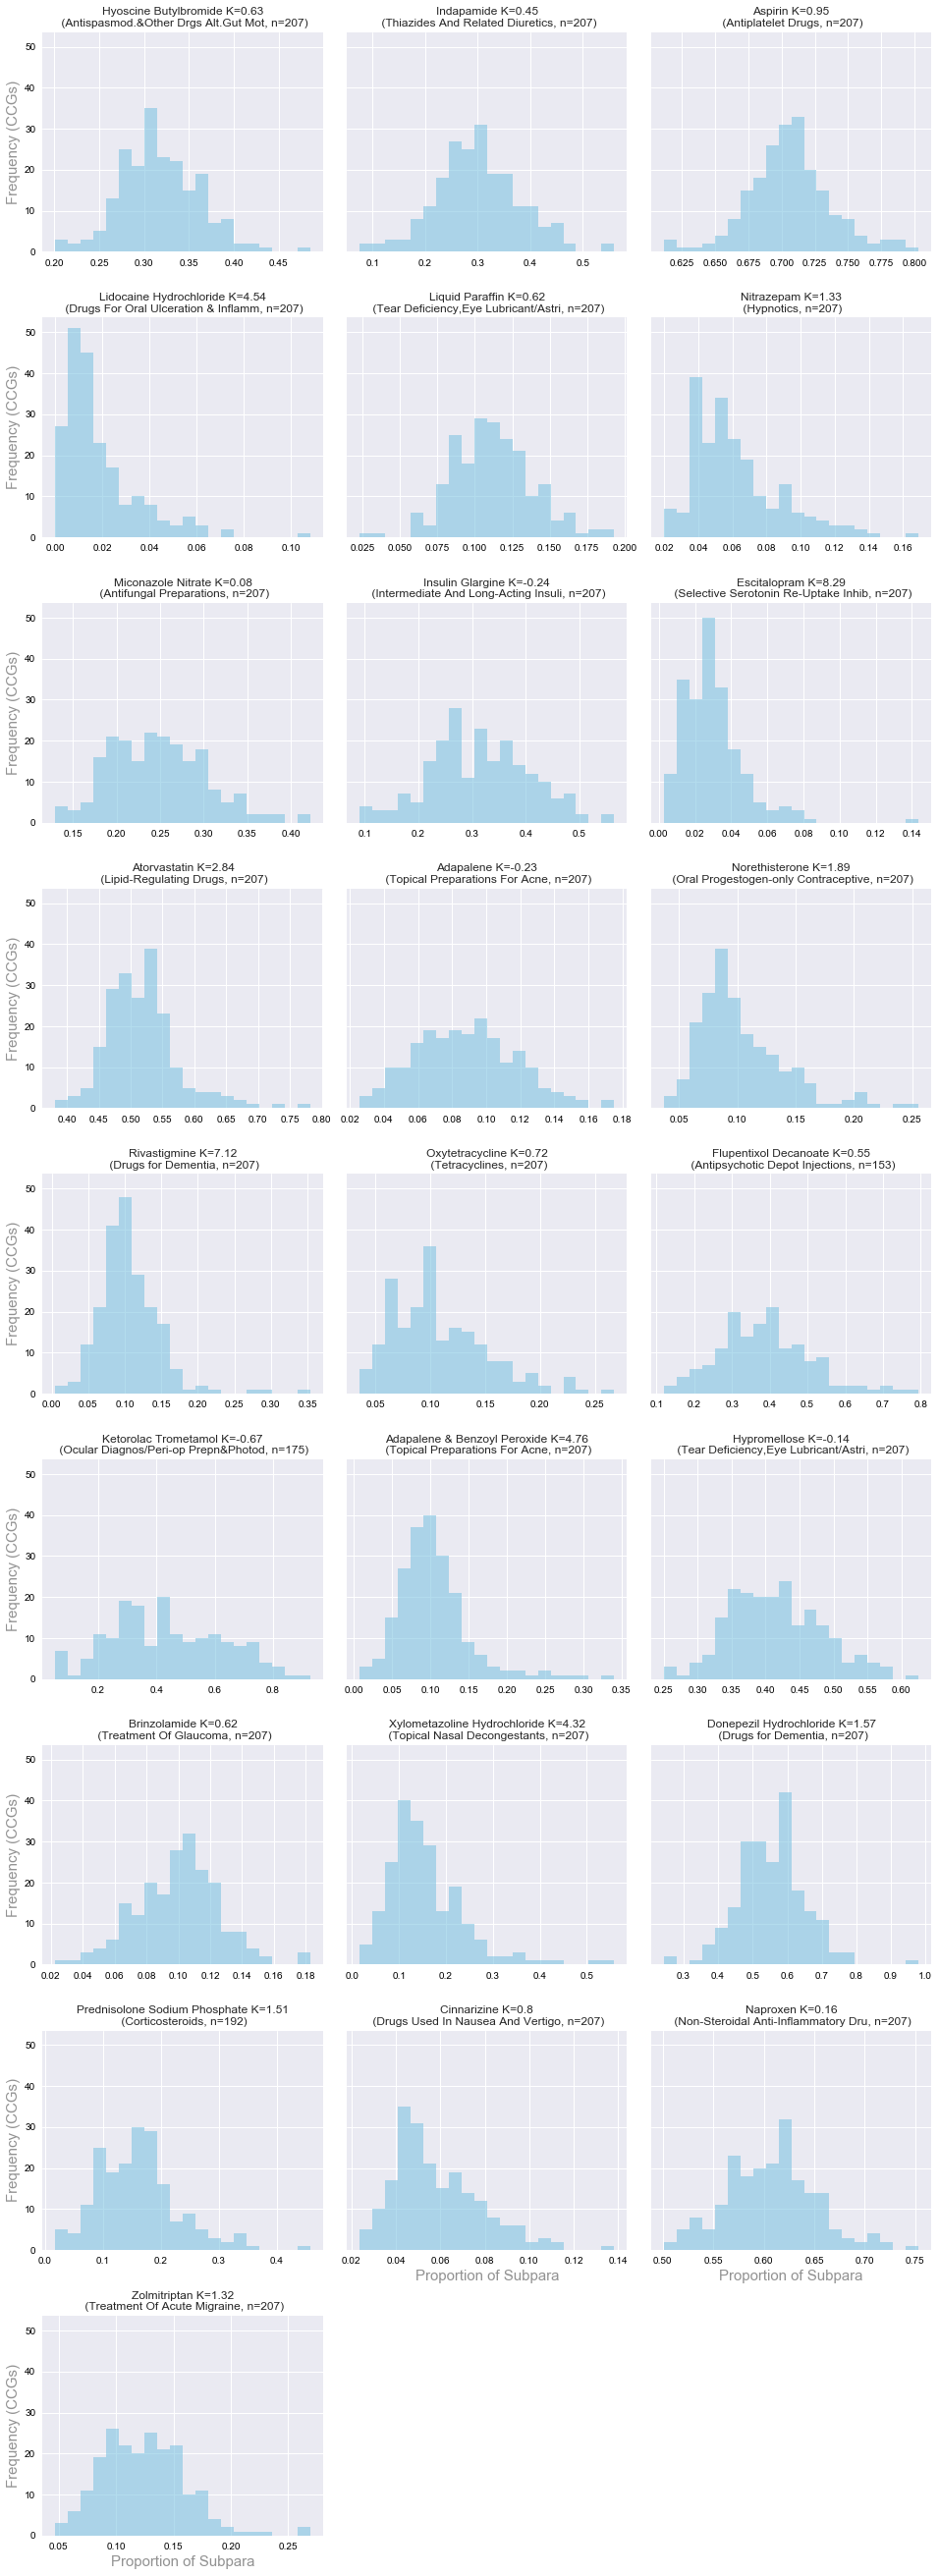

In [11]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy.sort_values(by="ratio2",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with largest ratio of 95-97th percentiles to 50-95th percentiles

In [33]:
smy2 = smy0
smy2["95-97"] = smy2["97%"]-smy2["95%"]
smy2["50-95"] = smy2["95%"]-smy2["50%"]
smy2["ratio2"] = smy2["95-97"]/smy2["50-95"]

smy2 = smy2.reset_index()
smy2 = smy2[["chemical","ratio2"]].merge(dfp, on="chemical")
smy2["M2"]  = -np.log(smy["ratio2"].rank(pct=True,ascending=False, method="min"))

smy2.sort_values(by="ratio2",ascending=False)


chemical    ratio2                        chemical name  subpara  \
105  0402010S0  1.804282              Promazine Hydrochloride  0402010   
104  0402010P0  0.880253                          Pericyazine  0402010   
284  090602700  0.871552       Other Vitamin B Compound Preps  0906027   
383  1306020J0  0.829108                         Isotretinoin  1306020   
15   0105010D0  0.793457                   Balsalazide Sodium  0105010   
101  0401020T0  0.775810                             Oxazepam  0401020   
301  100302010  0.761926                           Ketoprofen  1003020   
190  0601011P0  0.748109                    Insulin Glulisine  0601011   
1    0101010F0  0.745605                  Magnesium Carbonate  0101010   
59   0206040AF  0.736185           Nicotinic Acid Derivatives  0206040   
77   0301040R0  0.705329                           Salbutamol  0301040   
310  1103010Y0  0.646969                            Ofloxacin  1103010   
14   0103050R0  0.641177                         Pantoprazole  0103050   
257  0803042R0  0.628028                            Degarelix  0803042   
39   0203020R0  0.616192            Propafenone Hydrochloride  0203020   
176  0501070T0  0.593056                          Teicoplanin  0501070   
186  0504010L0  0.589413             Mefloquine Hydrochloride  0504010   
300  1002020T0  0.584337             Tizanidine Hydrochloride  1002020   
258  0803042S0  0.583852                 Triptorelin Embonate  0803042   
397  1310012K0  0.565699                        Metronidazole  1310012   
218  0604012S0  0.552834                         Progesterone  0604012   
156  0410020A0  0.544229              Bupropion Hydrochloride  0410020   
376  1305020R0  0.544127                           Tacalcitol  1305020   
72   0301020I0  0.519265                  Ipratropium Bromide  0301020   
208  0601023AQ  0.512065                          Dulaglutide  0601023   
8    0101010Q0  0.479770                  Magnesium Hydroxide  0101010   
409  1502010A0  0.477817                           Tetracaine  1502010   
282  090601100  0.469589        Other Vitamin A Preps 0906011  0906011   
4    0101010J0  0.466950                Magnesium Trisilicate  0101010   
187  0504010T0  0.447270                    Quinine Bisulfate  0504010   
..         ...       ...                                  ...      ...   
227  0702010F0  0.067338                              Estriol  0702010   
256  0803042P0  0.066297                  Triptorelin Acetate  0803042   
381  1306010I0  0.065963                         Erythromycin  1306010   
42   0204000R0  0.065651            Propranolol Hydrochloride  0204000   
26   0106070B0  0.064942                          Linaclotide  0106070   
106  0402020AA  0.060034                          Risperidone  0402020   
332  1108010L0  0.059362                      Liquid Paraffin  1108010   
148  0409010N0  0.057086    Co-Careldopa (Carbidopa/Levodopa)  0409010   
392  1309000I0  0.056116                         Ketoconazole  1309000   
157  0410020C0  0.055301                 Varenicline Tartrate  0410020   
248  0803041B0  0.055056                          Anastrozole  0803041   
391  1309000C0  0.049931                             Coal Tar  1309000   
245  0802010G0  0.049238                         Azathioprine  0802010   
117  0403030E0  0.049225             Fluoxetine Hydrochloride  0403030   
266  090401000  0.048345    Other Food For Special Diet Preps  0904010   
359  1203050P0  0.047588            Pilocarpine Hydrochloride  1203050   
76   0301030C0  0.046217                Aminophylline Hydrate  0301030   
262  0901020N0  0.045917                     Hydroxocobalamin  0901020   
192  0601012F0  0.041273              Biphasic Insulin Lispro  0601012   
147  0409010K0  0.041190  Co-Beneldopa (Benserazide/Levodopa)  0409010   
195  0601012W0  0.040355              Biphasic Insulin Aspart  0601012   
210  0601023X0  0.038037                          Sitagliptin  0601023   
174  05010

### Histograms for top chemicals by percentile ratio (95-97th)

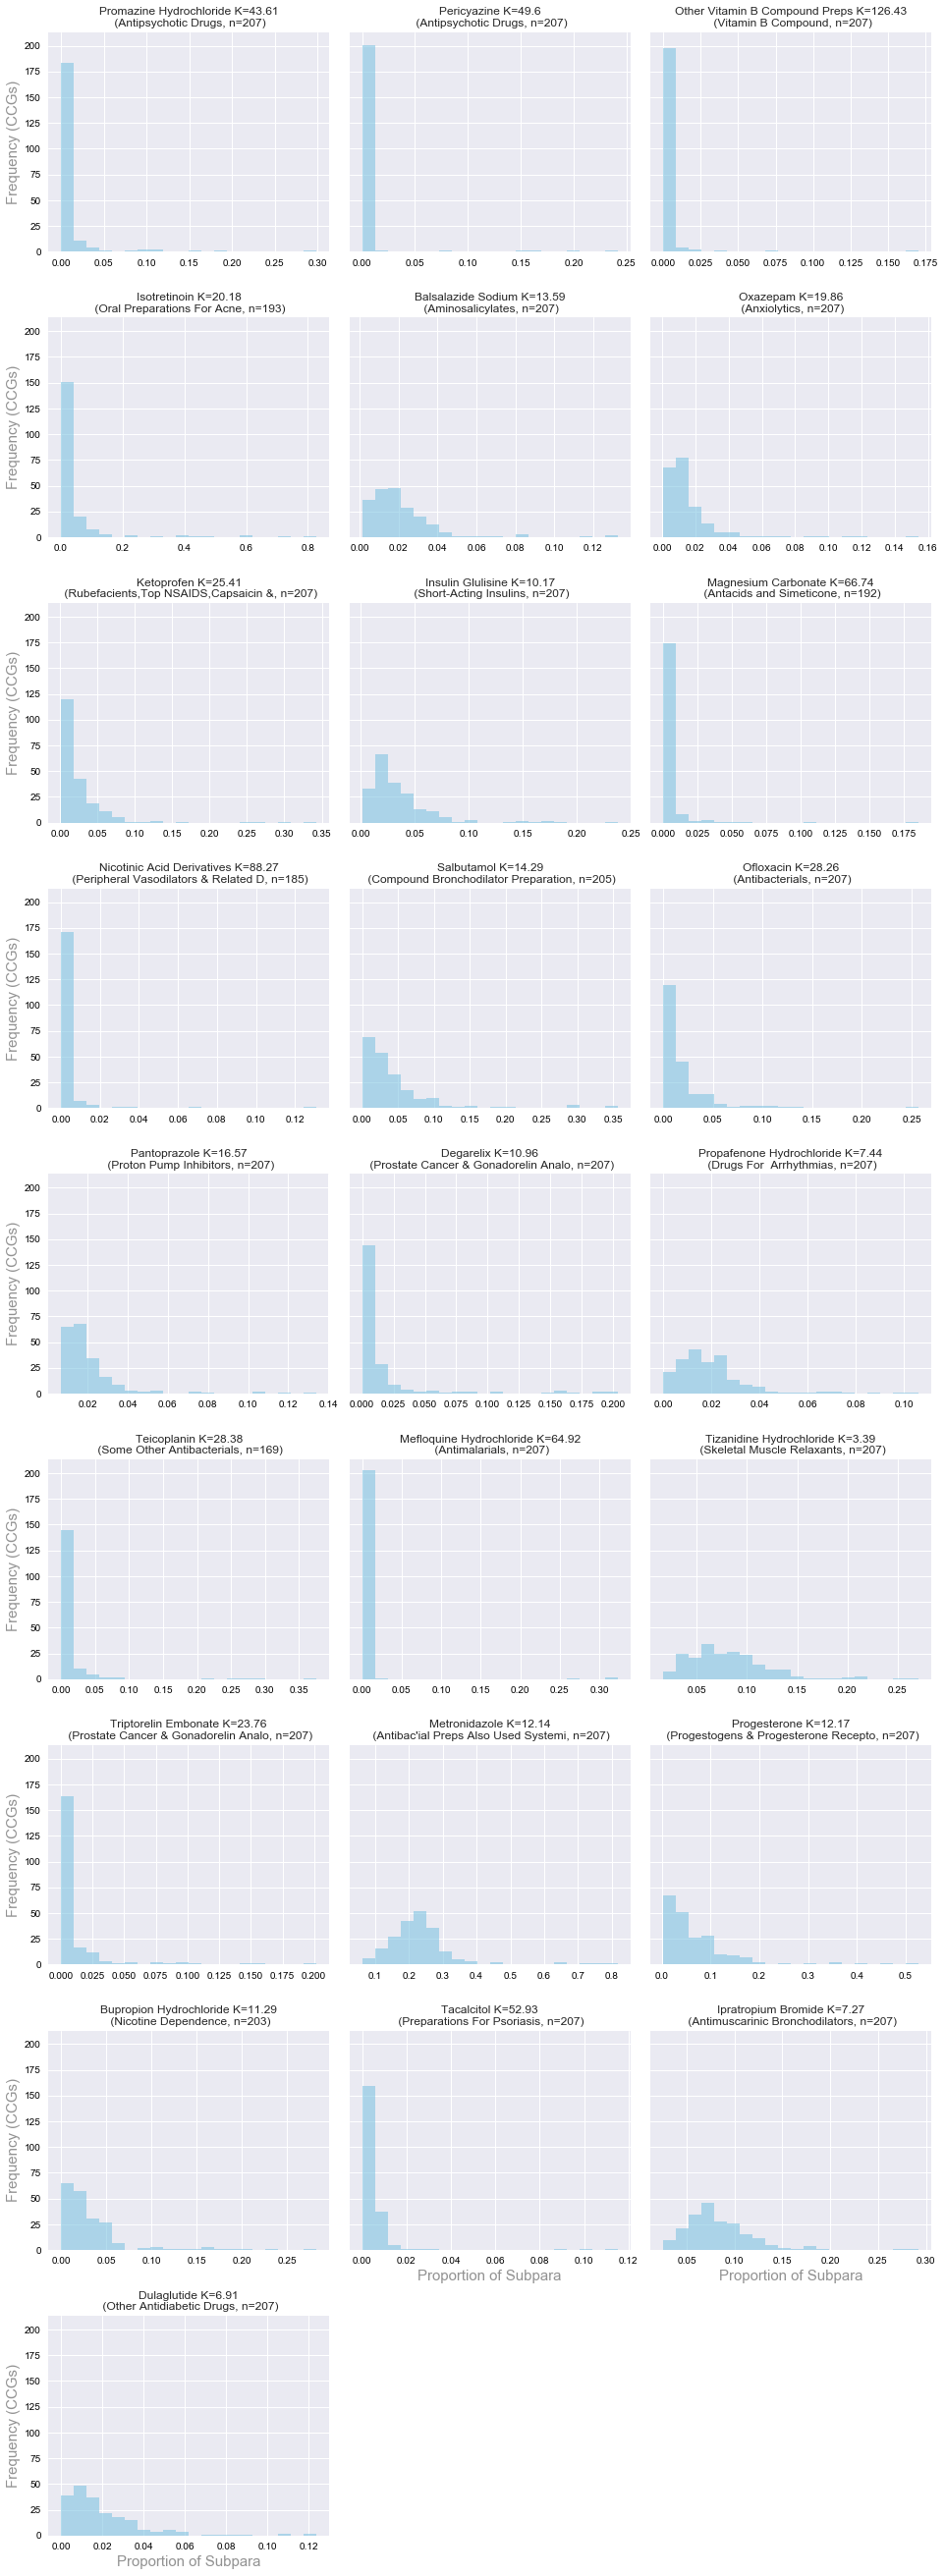

In [13]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy2.sort_values(by="ratio2",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with most CCGs outside IQR*1.5
This is a measure of general disagreement, mostly picks up chemicals with a wide spread of ratio values across CCGs

In [14]:
smy3 = smy0.reset_index()

# join back to dataset (unstacked)
dfx = data3.merge(smy3[["chemical","IQR","25%","75%"]], on="chemical")

#Calculate 1.5* IQR applied to upper and lower quartiles
dfx["1.5xIQR_LQ"] = dfx["25%"]-(dfx["IQR"]/2)
dfx["1.5xIQR_UQ"] = dfx["75%"]+(dfx["IQR"]/2)

#Calculate difference between each ratio and the 1.5IQR limits
dfx["diff_LQ"] = dfx["ratio"]-dfx["1.5xIQR_LQ"]
dfx["diff_UQ"] = dfx["1.5xIQR_UQ"]-dfx["ratio"]

# For each chemical, count how many CCGs are outside 1.5*IQR range
smy3 = dfx.loc[(dfx["diff_UQ"]<0) | (dfx["diff_LQ"]<0)].groupby("chemical")["pct"].count().sort_values(ascending=False)
smy3 = pd.DataFrame(smy3).reset_index().merge(dfp, on="chemical").rename(columns={"pct":"pct count"})
smy3["M3"]  = -np.log(smy3["pct count"].rank(pct=True,ascending=False, method="min"))
smy3


chemical  pct count                            chemical name  subpara  \
0    0406000J0         52                              Domperidone  0406000   
1    1106000AB         51                    Dorzolamide & Timolol  1106000   
2    0802010G0         50                             Azathioprine  0802010   
3    0105020A0         49                               Budesonide  0105020   
4    1306010C0         49                         Benzoyl Peroxide  1306010   
5    0206030Y0         49                               Ivabradine  0206030   
6    0604020K0         49                             Testosterone  0604020   
7    1001010J0         49                                Ibuprofen  1001010   
8    0304010D0         48                               Loratadine  0304010   
9    0209000A0         47                                  Aspirin  0209000   
10   0410020C0         47                     Varenicline Tartrate  0410020   
11   1001030C0         47               Hydroxychloroquine Sulfate  1001030   
12   0402030Q0         47                            Valproic Acid  0402030   
13   0504010T0         47                        Quinine Bisulfate  0504010   
14   1103010H0         46                             Fusidic Acid  1103010   
15   0102000T0         46                           Peppermint Oil  0102000   
16   1404000H0         46                                Influenza  1404000   
17   0803042S0         46                     Triptorelin Embonate  0803042   
18   0304010E0         46               Fexofenadine Hydrochloride  0304010   
19   040702040         46                   Tramadol Hydrochloride  0407020   
20   0202010P0         45                               Indapamide  0202010   
21   1106000L0         45                              Latanoprost  1106000   
22   0407041M0         45                Naratriptan Hydrochloride  0407041   
23   0704020AC         44                 Darifenacin Hydrobromide  0704020   
24   0208010W0         44                        Tinzaparin Sodium  0208010   
25   1106000AF         44                              Bimatoprost  1106000   
26   0601012W0         44                  Biphasic Insulin Aspart  0601012   
27   1309000I0         44                             Ketoconazole  1309000   
28   1108010B0         44                         Carbomer 940/980  1108010   
29   040201060         44                               Olanzapine  0402010   
..         ...        ...                                      ...      ...   
381  1104010R0         22                     Prednisolone Acetate  1104010   
382  1104010S0         22            Prednisolone Sodium Phosphate  1104010   
383  0905022T0         21                      Lanthanum Carbonate  0905022   
384  0605010G0         21                        Clomifene Citrate  0605010   
385  0906011H0         21                            Cod Liver Oil  0906011   
386  0410020A0         21                  Bupropion Hydrochloride  0410020   
387  0407010N0         20     Co-Dydramol (Dihydrocodeine/Paracet)  0407010   
388  110802070         20                     Ketorolac Trometamol  1108020   
389  0704020AD         20                    Fesoterodine Fumarate  0704020   
390  0801030P0         19                             Methotrexate  0801030   
391  090605000         19            Other Vitamin E Preps 0906050  0906050   
392  1308010Y0         19                 Fluorouracil (Sunscreen)  1308010   
393  1302020D0         19                     Dimeticone (Barrier)  1302020   
394  130801000         19                 Other Sunscreening Preps  1308010   
395  0404000U0         18              Lisdexamfetamine Dimesylate  0404000   
396  0409030P0         18                                Piracetam  0409030   
397  0402020AA         17                              Risperidone  0402020   
398  0501070U0         17                 Vancomycin Hydrochloride  0501070   
399  1106000AE         16                               

### Histograms for top 25 chemicals with most CCGs outside 1.5x IQR

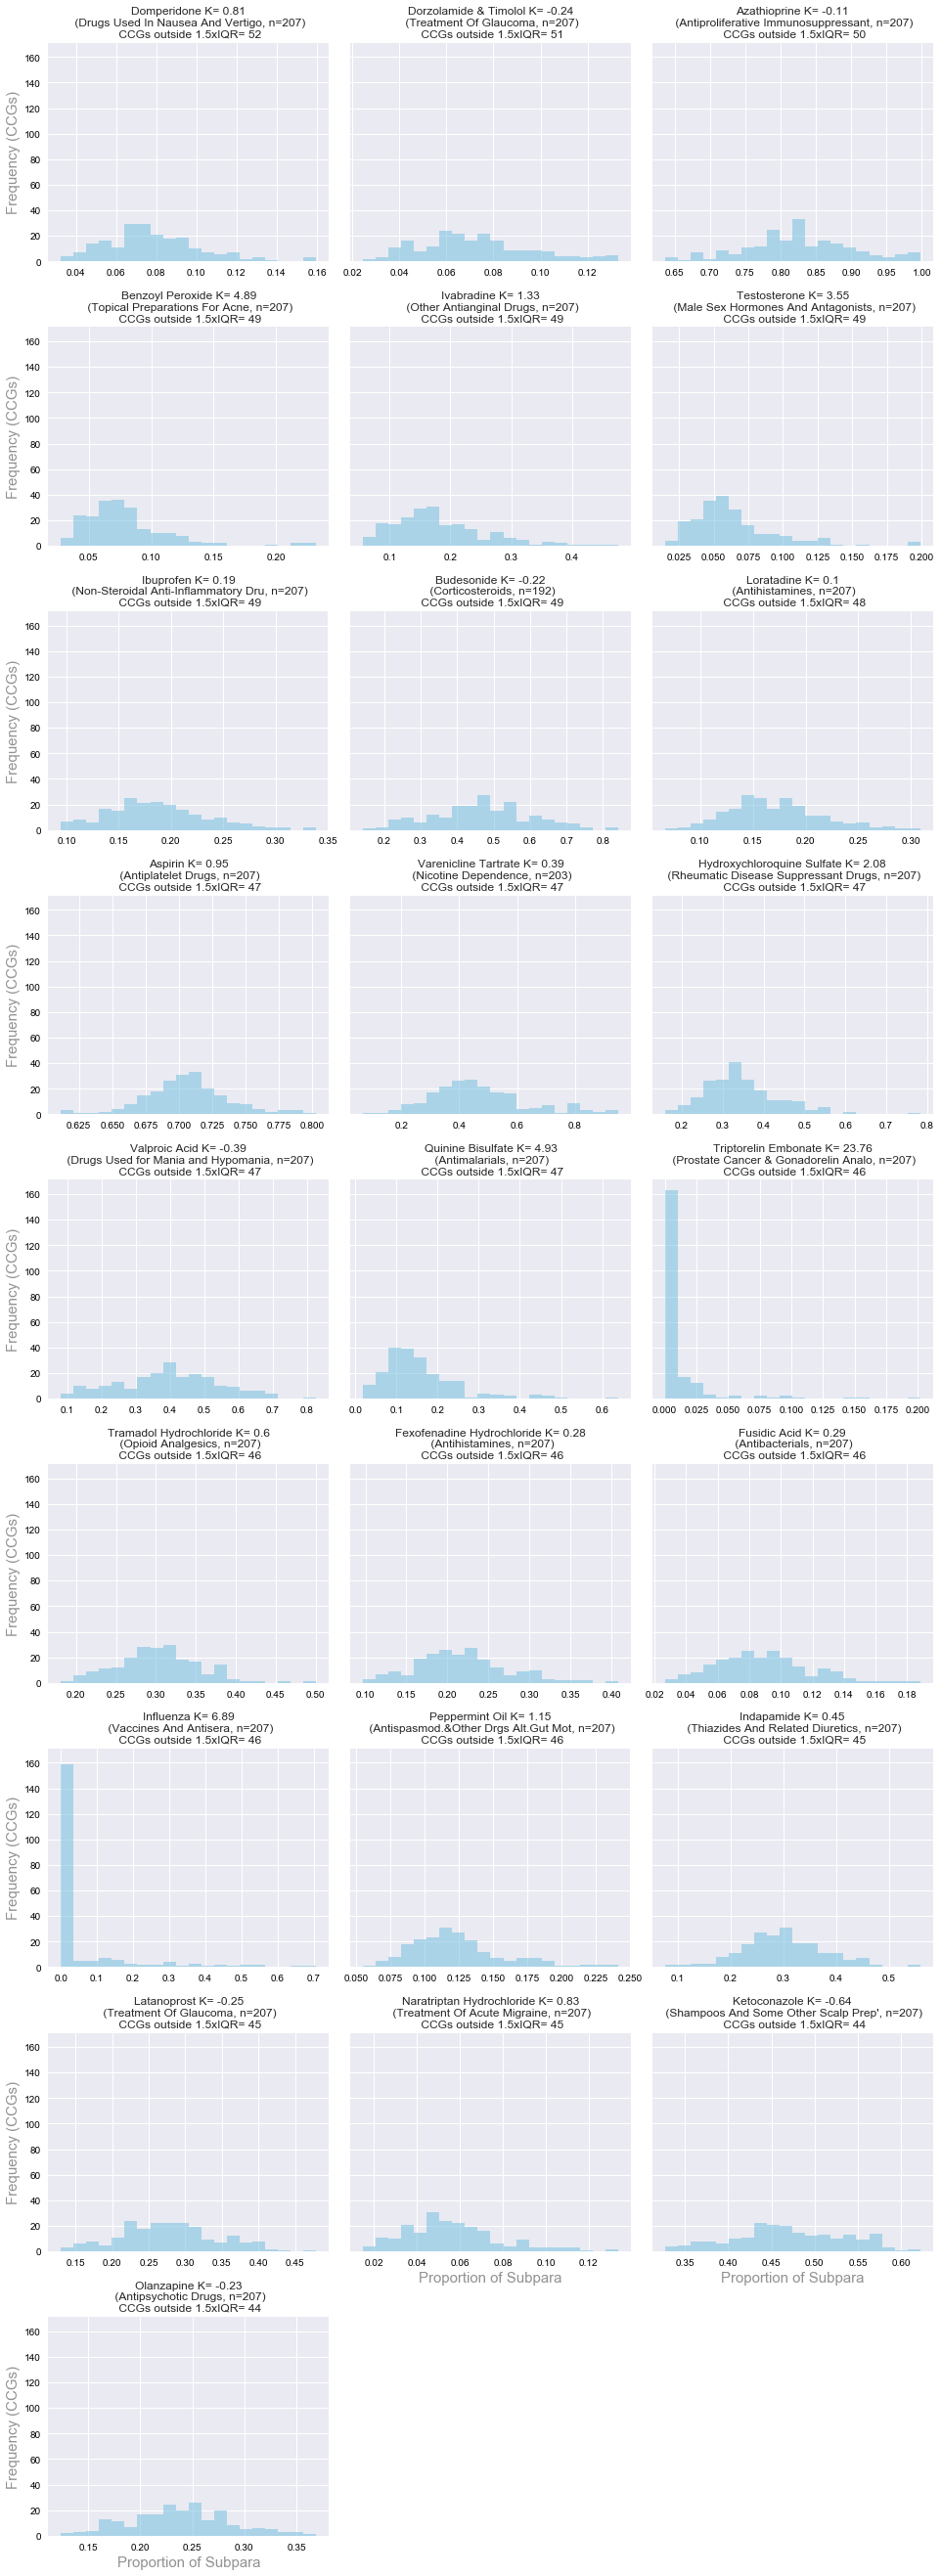

In [15]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy3.sort_values(by="M3",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","pct count"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","pct count"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n CCGs outside 1.5xIQR= "+titles["pct count"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with with fewest no of CCGs outside IQR
(no of CCGs outside IQR calculated as a proportion of CCGs prescribing items from the subparagraph)

In [16]:
dfx2 = dfx

#Calculate difference between each ratio and the IQR limits
dfx2["diff_LQ"] = dfx2["ratio"]-dfx2["25%"]
dfx2["diff_UQ"] = dfx2["75%"]-dfx2["ratio"]
dfx2

# For each chemical, count how many CCGs are outside IQR range
smy4 = dfx2.loc[(dfx["diff_UQ"]<0) | (dfx2["diff_LQ"]<0)].groupby("chemical")["pct"].count().sort_values()
smy4 = pd.DataFrame(smy4).reset_index().merge(dfp, on="chemical").rename(columns={"pct":"pct count"})
#calculate no of ccgs as a ratio
smy4["pct ratio"] = smy4["pct count"]/smy4["count"]
#rank:
smy4["M4"]  = -np.log(smy4["pct ratio"].rank(pct=True, method="min"))
smy4.sort_values(by="pct ratio")


chemical  pct count                           chemical name  subpara  \
1    0206040AF         24              Nicotinic Acid Derivatives  0206040   
4    0101010F0         25                     Magnesium Carbonate  0101010   
2    1310011AA         25                             Retapamulin  1310011   
3    090603100         25   Other Vitamin C (Ascorbic Acid) Preps  0906031   
6    0905013P0         31                       Magnesium Lactate  0905013   
16   0905022W0         40                Sucroferric Oxyhydroxide  0905022   
7    0905013N0         33                       Magnesium Sulfate  0905013   
17   0501070T0         41                             Teicoplanin  0501070   
11   090601100         37           Other Vitamin A Preps 0906011  0906011   
13   0402020AD         38                            Aripiprazole  0402020   
12   0402020AB         38                            Paliperidone  0402020   
18   0501070N0         42                         Sodium Fusidate  0501070   
23   0206040AI         46                Moxisylyte Hydorchloride  0206040   
26   1306020J0         48                            Isotretinoin  1306020   
14   0905013F0         39                       Magnesium Citrate  0905013   
30   0101010P0         48  Co-Simalcite (Simeticone/Hydrotalcite)  0101010   
29   0101010Q0         48                     Magnesium Hydroxide  0101010   
28   0101010I0         48                         Magnesium Oxide  0101010   
27   0101010C0         48                     Aluminium Hydroxide  0101010   
33   0905022U0         49     Calcium Acetate/Magnesium Carbonate  0905022   
24   0902011L0         48           Calcium Polystyrene Sulfonate  0902011   
10   1002010M0         35                     Neostigmine Bromide  1002010   
5    0605010D0         31                 Chorionic Gonadotrophin  0605010   
21   0410030B0         44             Buprenorph HCl/Naloxone HCl  0410030   
9    090605000         34           Other Vitamin E Preps 0906050  0906050   
31   0105020G0         48   Beclometasone Dipropionate (Systemic)  0105020   
15   1105000S0         40                             Tropicamide  1105000   
32   0101010N0         48      Aluminium & Magnesium & Oxetacaine  0101010   
36   0501021B0         52                              Cefadroxil  0501021   
34   0803042S0         52                    Triptorelin Embonate  0803042   
..         ...        ...                                     ...      ...   
206  1002020J0        104                       Dantrolene Sodium  1002020   
410  0501013K0        104  Co-Amoxiclav (Amoxicillin/Clavul Acid)  0501013   
204  1106000L0        104                             Latanoprost  1106000   
203  1304000V0        104                          Hydrocortisone  1304000   
113  0410020A0        102                 Bupropion Hydrochloride  0410020   
103  0410020C0        102                    Varenicline Tartrate  0410020   
98   1310040V0        100              Dimeticone (Parasiticidal)  1310040   
99   0902021S0        100                         Sodium Chloride  0902021   
100  1310040M0        100                               Malathion  1310040   
86   0205010N0         96                               Minoxidil  0205010   
71   0408020V0         88                       Midazolam Maleate  0408020   
73   1108020AG         88                               Bromfenac  1108020   
74   1108020J0         88                           Apraclonidine  1108020   
75   1108020AF         88                               Nepafenac  1108020   
69   1108020A0         88                       Diclofenac Sodium  1108020   
65   0410010B0         84                              Disulfiram  0410010   
59   1201030F0         78                         Docusate Sodium  1201030   
58   1201030H0         78                        Oils For The Ear  1201030   
55   1201030N0         78                  Urea Hydrogen Peroxide  1201030   
48   1203050P0         70   

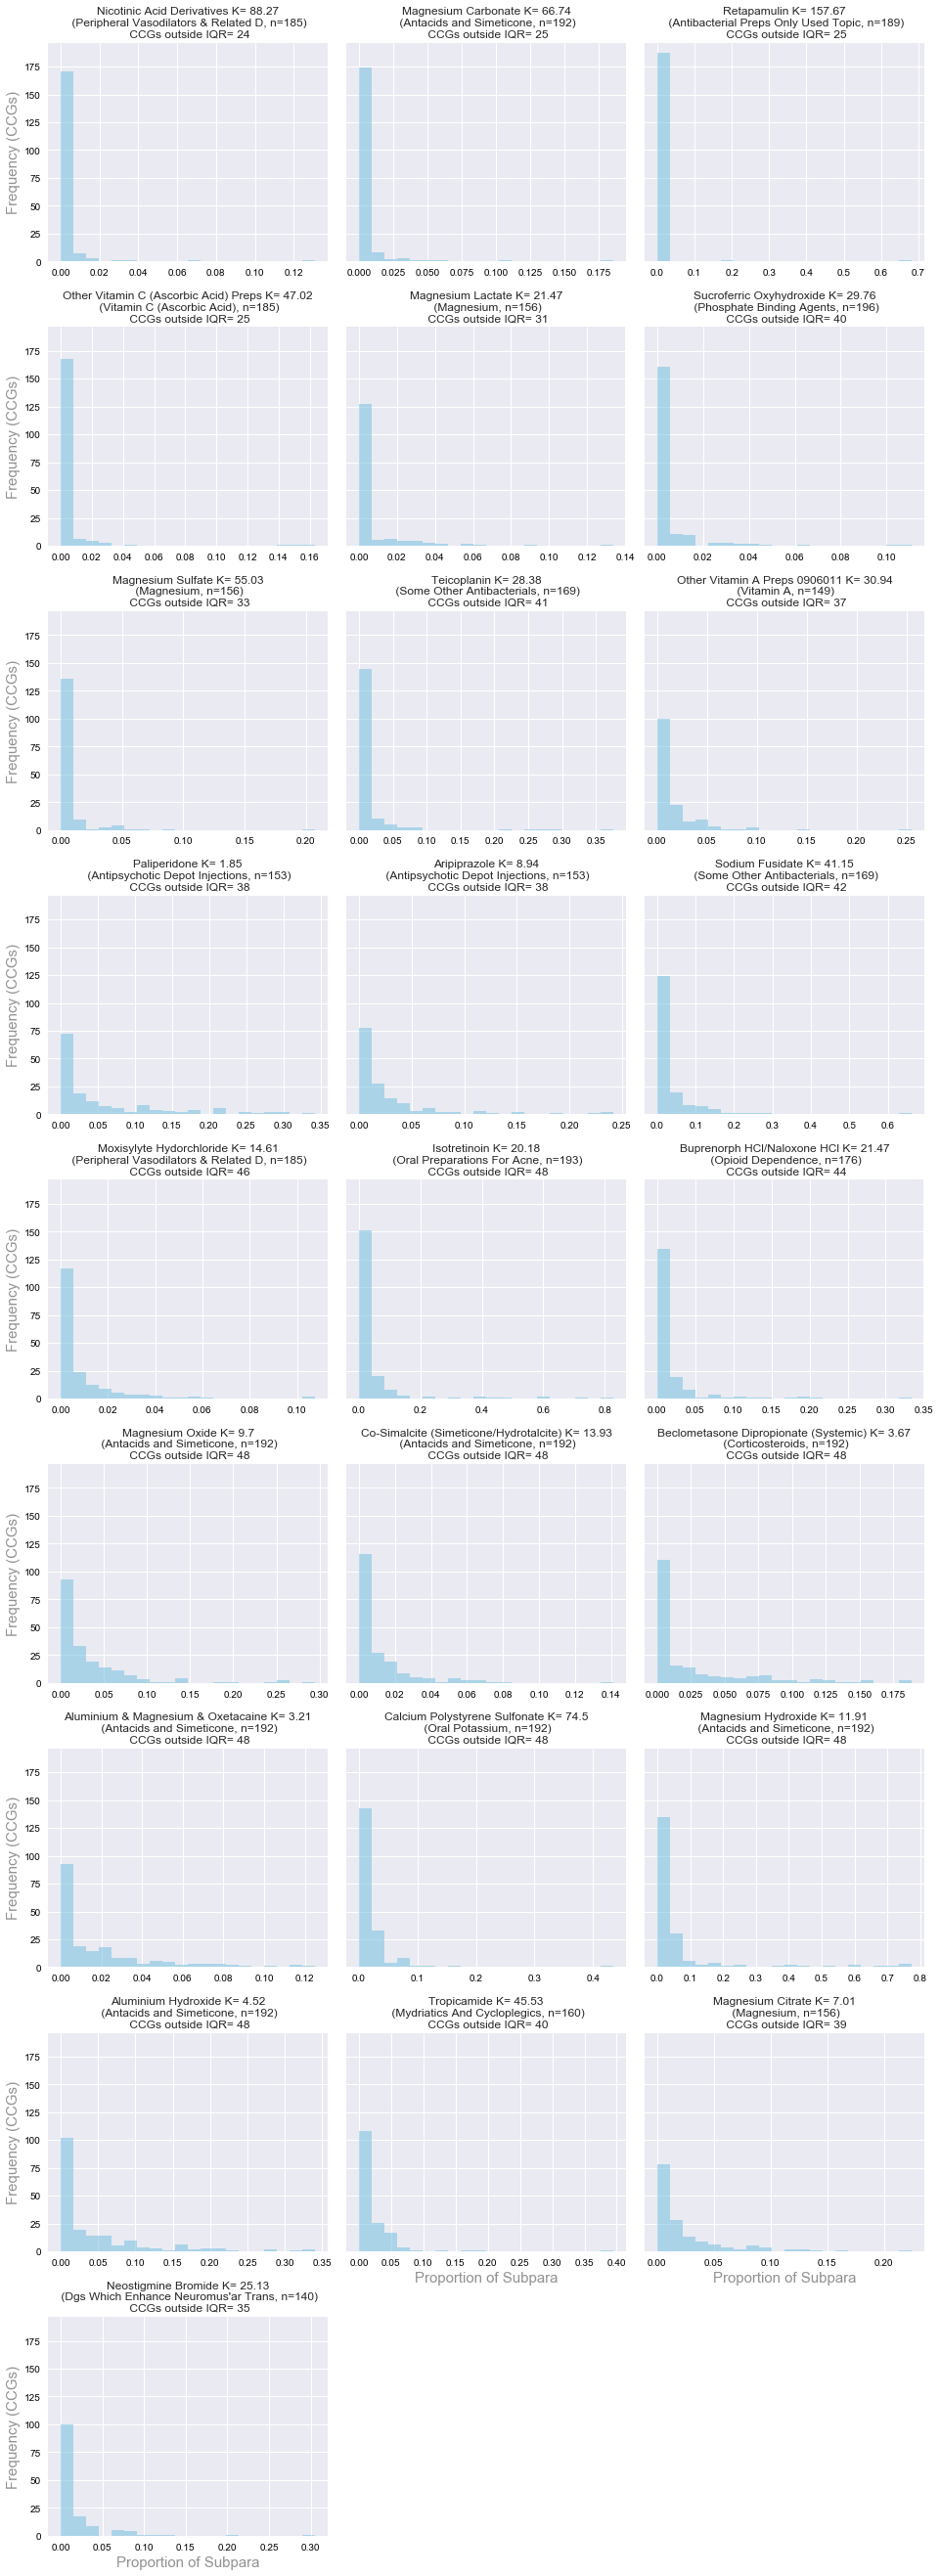

In [17]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy4.sort_values(by="M4",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","pct count"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","pct count"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n CCGs outside IQR= "+titles["pct count"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals with 97th centile at X times IQR from median, ranked by X

In [18]:
smy5 = smy0

smy5["3-50"] = smy5["50%"]-smy5["3%"]
smy5["50-97"] = smy5["97%"]-smy5["50%"]
smy5["ratio1"] = (smy5["3-50"]/smy5["IQR"]).round(2)
smy5["ratio2"] = (smy5["50-97"]/smy5["IQR"]).round(2)

# lower percentiles
smy5a = smy5.sort_values(by="ratio1",ascending=False).reset_index()
smy5a = smy5a[["chemical","ratio1"]].merge(dfp, on="chemical").rename(columns={"ratio1":"percentile ratio"})
smy5a["M5"]  = -np.log(smy5a["percentile ratio"].rank(pct=True, ascending=False, method="min"))

# upper percentiles
smy5b = smy5.sort_values(by="ratio2",ascending=False).reset_index()
smy5b = smy5b[["chemical","ratio2"]].merge(dfp, on="chemical").rename(columns={"ratio2":"percentile ratio"})
smy5b["M5"]  = -np.log(smy5b["percentile ratio"].rank(pct=True, ascending=False, method="min"))

#smy5c = smy5b.append(smy5a)
smy5b

chemical  percentile ratio                           chemical name  \
0    0905013N0               inf                       Magnesium Sulfate   
1    0905013P0               inf                       Magnesium Lactate   
2    0905022W0               inf                Sucroferric Oxyhydroxide   
3    090603100               inf   Other Vitamin C (Ascorbic Acid) Preps   
4    0501070T0               inf                             Teicoplanin   
5    0101010F0               inf                     Magnesium Carbonate   
6    1310011AA               inf                             Retapamulin   
7    0206040AF               inf              Nicotinic Acid Derivatives   
8    0402010S0         24.820000                 Promazine Hydrochloride   
9    0501021B0         16.940000                              Cefadroxil   
10   0803042S0         15.710000                    Triptorelin Embonate   
11   1404000H0         15.380000                               Influenza   
12   0601021P0         13.400000                               Glipizide   
13   0704020AC         12.950000                Darifenacin Hydrobromide   
14   0101010Q0         12.760000                     Magnesium Hydroxide   
15   0803042R0         12.600000                               Degarelix   
16   1306020J0         12.150000                            Isotretinoin   
17   0410030B0          9.030000             Buprenorph HCl/Naloxone HCl   
18   1302010Y0          8.980000                           Wool Alcohols   
19   0504010L0          8.540000                Mefloquine Hydrochloride   
20   090602700          8.400000          Other Vitamin B Compound Preps   
21   1108020K0          7.580000                      Fluorescein Sodium   
22   0601021X0          6.650000                             Tolbutamide   
23   0402010P0          6.530000                             Pericyazine   
24   0905022U0          6.240000     Calcium Acetate/Magnesium Carbonate   
25   0803042P0          6.240000                     Triptorelin Acetate   
26   0501021M0          5.780000                               Cefradine   
27   1002010M0          5.760000                     Neostigmine Bromide   
28   0410010D0          5.700000                               Nalmefene   
29   1310011W0          5.420000                              Polymyxins   
..         ...               ...                                     ...   
382  040702040          1.350000                  Tramadol Hydrochloride   
383  0409010N0          1.340000       Co-Careldopa (Carbidopa/Levodopa)   
384  1302020D0          1.330000                    Dimeticone (Barrier)   
385  1308010W0          1.320000                       Diclofenac Sodium   
386  0501070X0          1.320000                               Rifaximin   
387  1106000AC          1.320000                            Brinzolamide   
388  0403030Q0          1.320000                Sertraline Hydrochloride   
389  1308010Y0          1.310000                Fluorouracil (Sunscreen)   
390  0407042F0          1.310000                 Clonidine Hydrochloride   
391  090401030          1.310000                       Gluten Free Mixes   
392  0501013K0          1.290000  Co-Amoxiclav (Amoxicillin/Clavul Acid)   
393  1309000C0          1.290000                                Coal Tar   
394  0301040W0          1.280000            Umeclidinium Brom/Vilanterol   
395  0208010L0          1.280000                       Dalteparin Sodium   
396  1309000I0          1.260000                            Ketoconazole   
397  0409010H0          1.250000                Ropinirole Hydrochloride   
398  0406000P0          1.240000            Metoclopramide Hydrochloride   
399  0409010K0          1.220000     Co-Beneldopa (Benserazide/Levodopa)   
400  0206010F0          1.220000                     Glyceryl Trinitrate   
401  110802070          1.220000                    Ketorolac Trometamol   
402  0905013A0          1.170000                     M

### Histograms for Chemicals with 97th centile at X times IQR from median, ranked by X

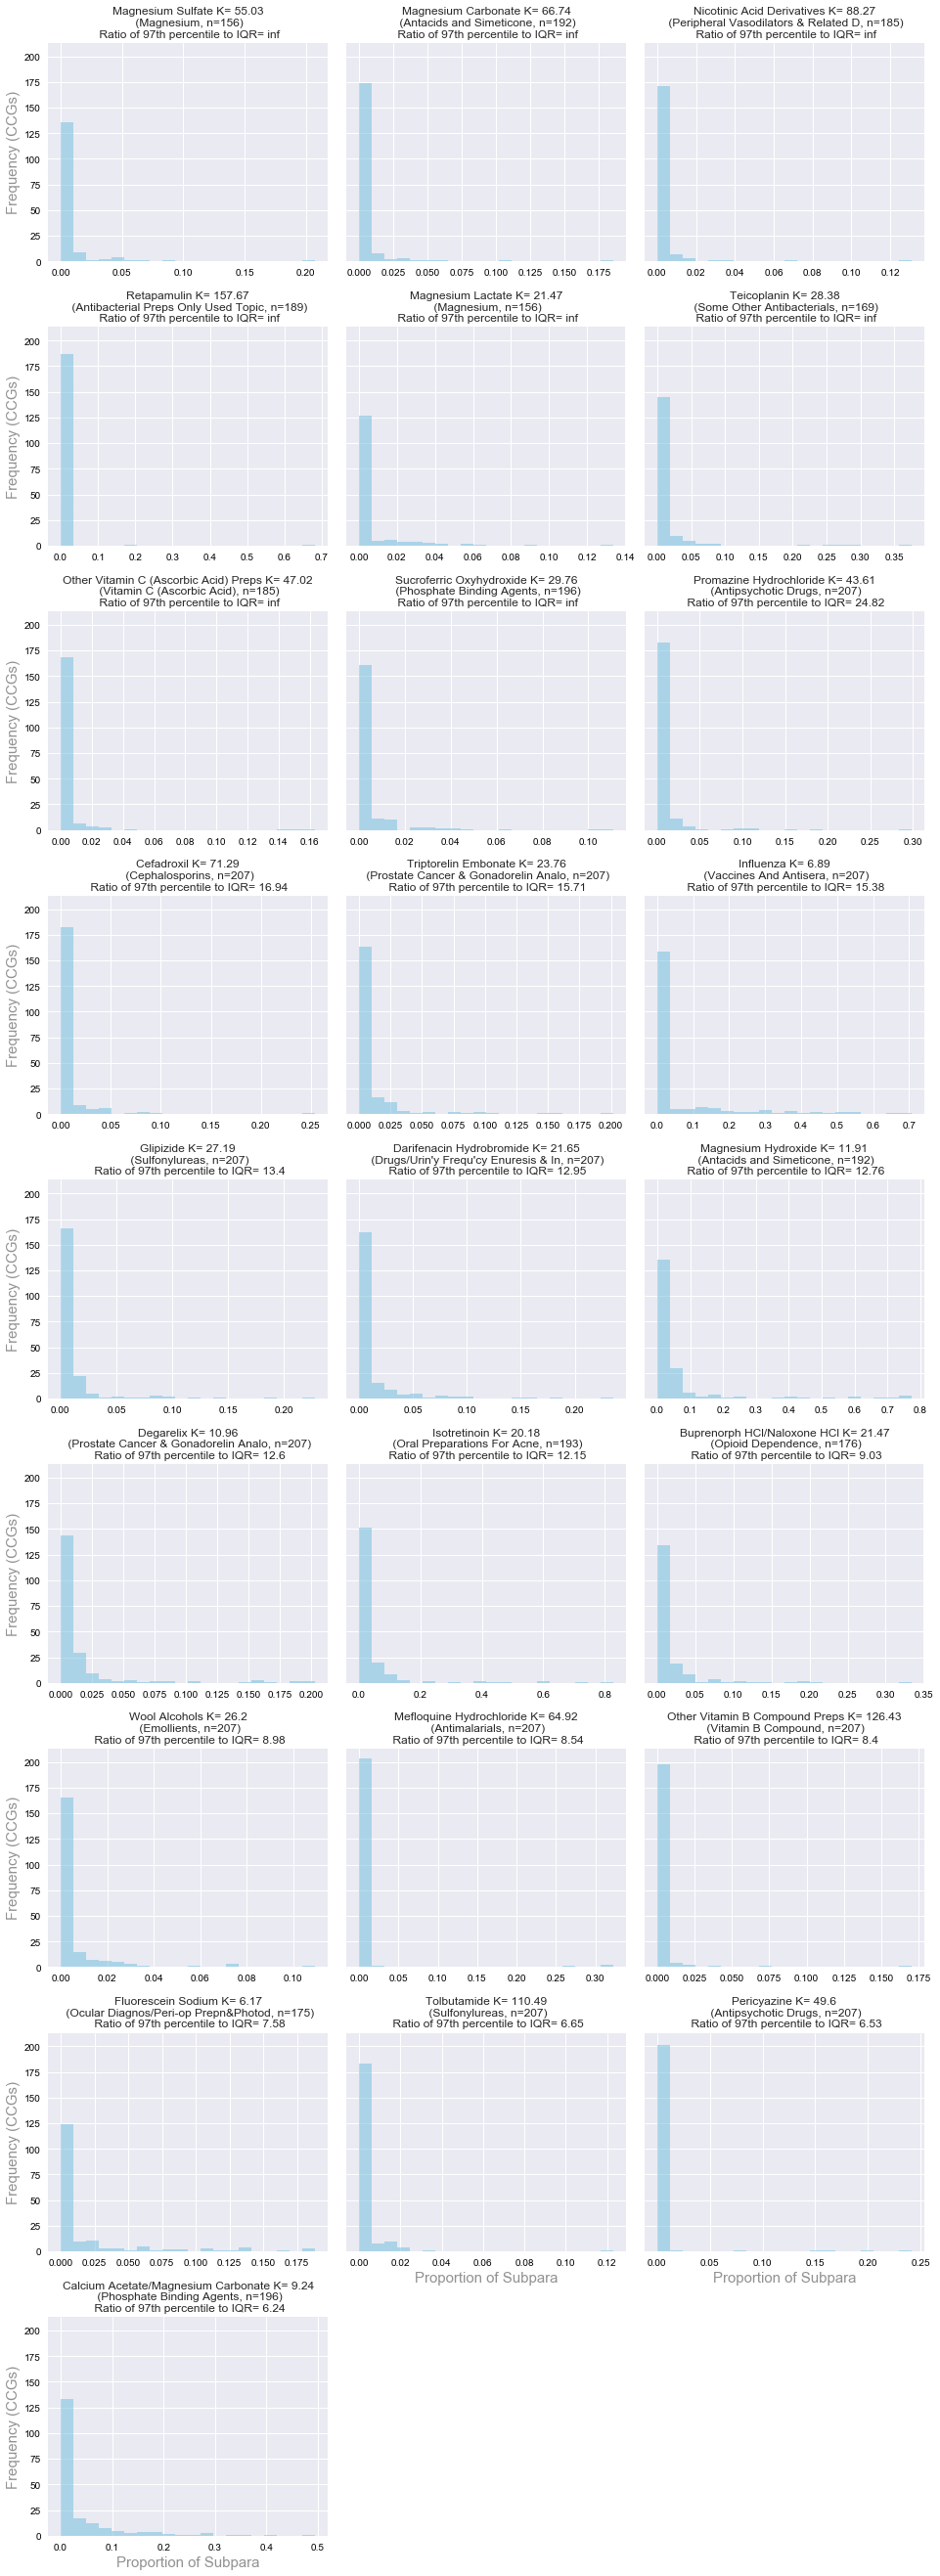

In [19]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy5b.sort_values(by="M5",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","percentile ratio"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","percentile ratio"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n Ratio of 97th percentile to IQR= "+titles["percentile ratio"].map(str)
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

### Chemicals where 60% of CCGs prescribe 0 but the total nationally is > X items over 3mo period, ranked by X
Note - chemicals in subparagraphs prescribed by <50 CCGs have been filtered out

In [26]:
smy6 = df4
smy6["ratio_non_p"] = (smy6["count"] - smy6["count2"]) / smy6["count"]
'''smy6 = pd.DataFrame(data3.loc[data3.num==0].groupby("chemical")["pct"].count()).reset_index()
#ct = pd.DataFrame(data3.groupby("chemical")["num"].count()).reset_index()
smy6 = smy6.merge(df4.reset_index(), on="chemical").drop("index",axis=1).rename(columns={"pct":"pct count"})
#smy6 =smy6.merge(ct.reset_index(), on="chemical")
smy6["ratio non-p"] = smy6["pct count"]/smy6["count"]'''

smy6 = smy6.loc[smy6["ratio_non_p"]>0.6].sort_values(by="num_total",ascending=False)
smy6["M6"]  = -np.log(smy6["num_total"].rank(pct=True, ascending=False, method="min"))
smy6

chemical                             chemical name  subpara  \
94   1502010P0                 Mepivacaine Hydrochloride  1502010   
4    0402010C0                                 Clozapine  0402010   
7    1310011AA                               Retapamulin  1310011   
299  0409010AA                                Safinamide  0409010   
90   1001022Y0                Triamcinolone Hexacetonide  1001022   
44   0403040S0                                Tryptophan  0403040   
469  1108020K0                        Fluorescein Sodium  1108020   
26   0402010AE                              Paliperidone  0402010   
205  0208010AB                       Fondaparinux Sodium  0208010   
119  0501070T0                               Teicoplanin  0501070   
212  0406000W0                    Ketamine Hydrochloride  0406000   
297  0205040M0            Phenoxybenzamine Hydrochloride  0205040   
318  0902021Q0                        Sodium Bicarbonate  0902021   
336  1001040K0                                Probenecid  1001040   
126  0401010AC                            Sodium Oxybate  0401010   
77   0402030R0                                 Asenapine  0402030   
83   0906040P0                              Paricalcitol  0906040   
70   0901011Y0                             Ferric Maltol  0901011   
362  040101000                      Other Hypnotic Preps  0401010   
162  0202040V0                Triamterene With Thiazides  0202040   
121  0409010P0                        Pergolide Mesilate  0409010   
113  0905022W0                  Sucroferric Oxyhydroxide  0905022   
254  120304000  Other Mouth Wash,Gargle&Dentifrice Preps  1203040   
67   0406000M0                 Granisetron Hydrochloride  0406000   
168  0704010C0                      Bethanechol Chloride  0704010   
214  0208020N0                               Phenindione  0208020   
165  0102000H0                      Belladonna Alkaloids  0102000   
317  0409010S0                                 Tolcapone  0409010   
148  1002010M0                       Neostigmine Bromide  1002010   
293  0206020M0                                Nimodipine  0206020   
..         ...                                       ...      ...   
36   0601060X0                                       NaN  0601060   
87   0601012G0                   Insulin Zinc Suspension  0601012   
219  1103010E0              Dibrompropamidine Isetionate  1103010   
64   0409020E0                     Benzatropine Mesilate  0409020   
276  0206020I0                                Isradipine  0206020   
268  0304010AE                       Rupatadine Fumarate  0304010   
236  0408010P0                         Phenobarbital Sod  0408010   
48   0408010Y0                                  Sultiame  0408010   
65   090603100     Other Vitamin C (Ascorbic Acid) Preps  0906031   
41   0309020I0                                    Squill  0309020   
146  0402010Q0                              Perphenazine  0402010   
84   0401010D0                   Clomethiazole Edisilate  0401010   
225  0407010M0        Co-Codaprin (Codeine Phos/Aspirin)  0407010   
95   0601012U0                    Protamine Zinc Insulin  0601012   
222  0501070M0                              Fusidic Acid  0501070   
14   0504010M0                   Proguanil Hydrochloride  0504010   
202  0102000AC                          Atropine Sulfate  0102000   
203  1303000B0                                Benzocaine  1303000   
135  0605010T0                            Tetracosactide  0605010   
110  0205051AA                      Perindopril Tosilate  0205051   
22   0604011AD   Oestrogens Conjugated with Bazedoxifene  0604011   
8    1502010S0                  Prilocaine Hydrochloride  1502010   
24   0206040AF                Nicotinic Acid Derivatives  0206040   
5    0501013C0                        Amoxicillin Sodium  0501013   
9    020400030                     Timolol With Diuretic  0204000   
57   0212000AJ                   Fenofibrate/Simvastatin  0212000   
134 

### Histograms for Chemicals where 60% CCGs prescribe zero
Note - chemicals in subparagraphs prescribed by <50 CCGs have been filtered out

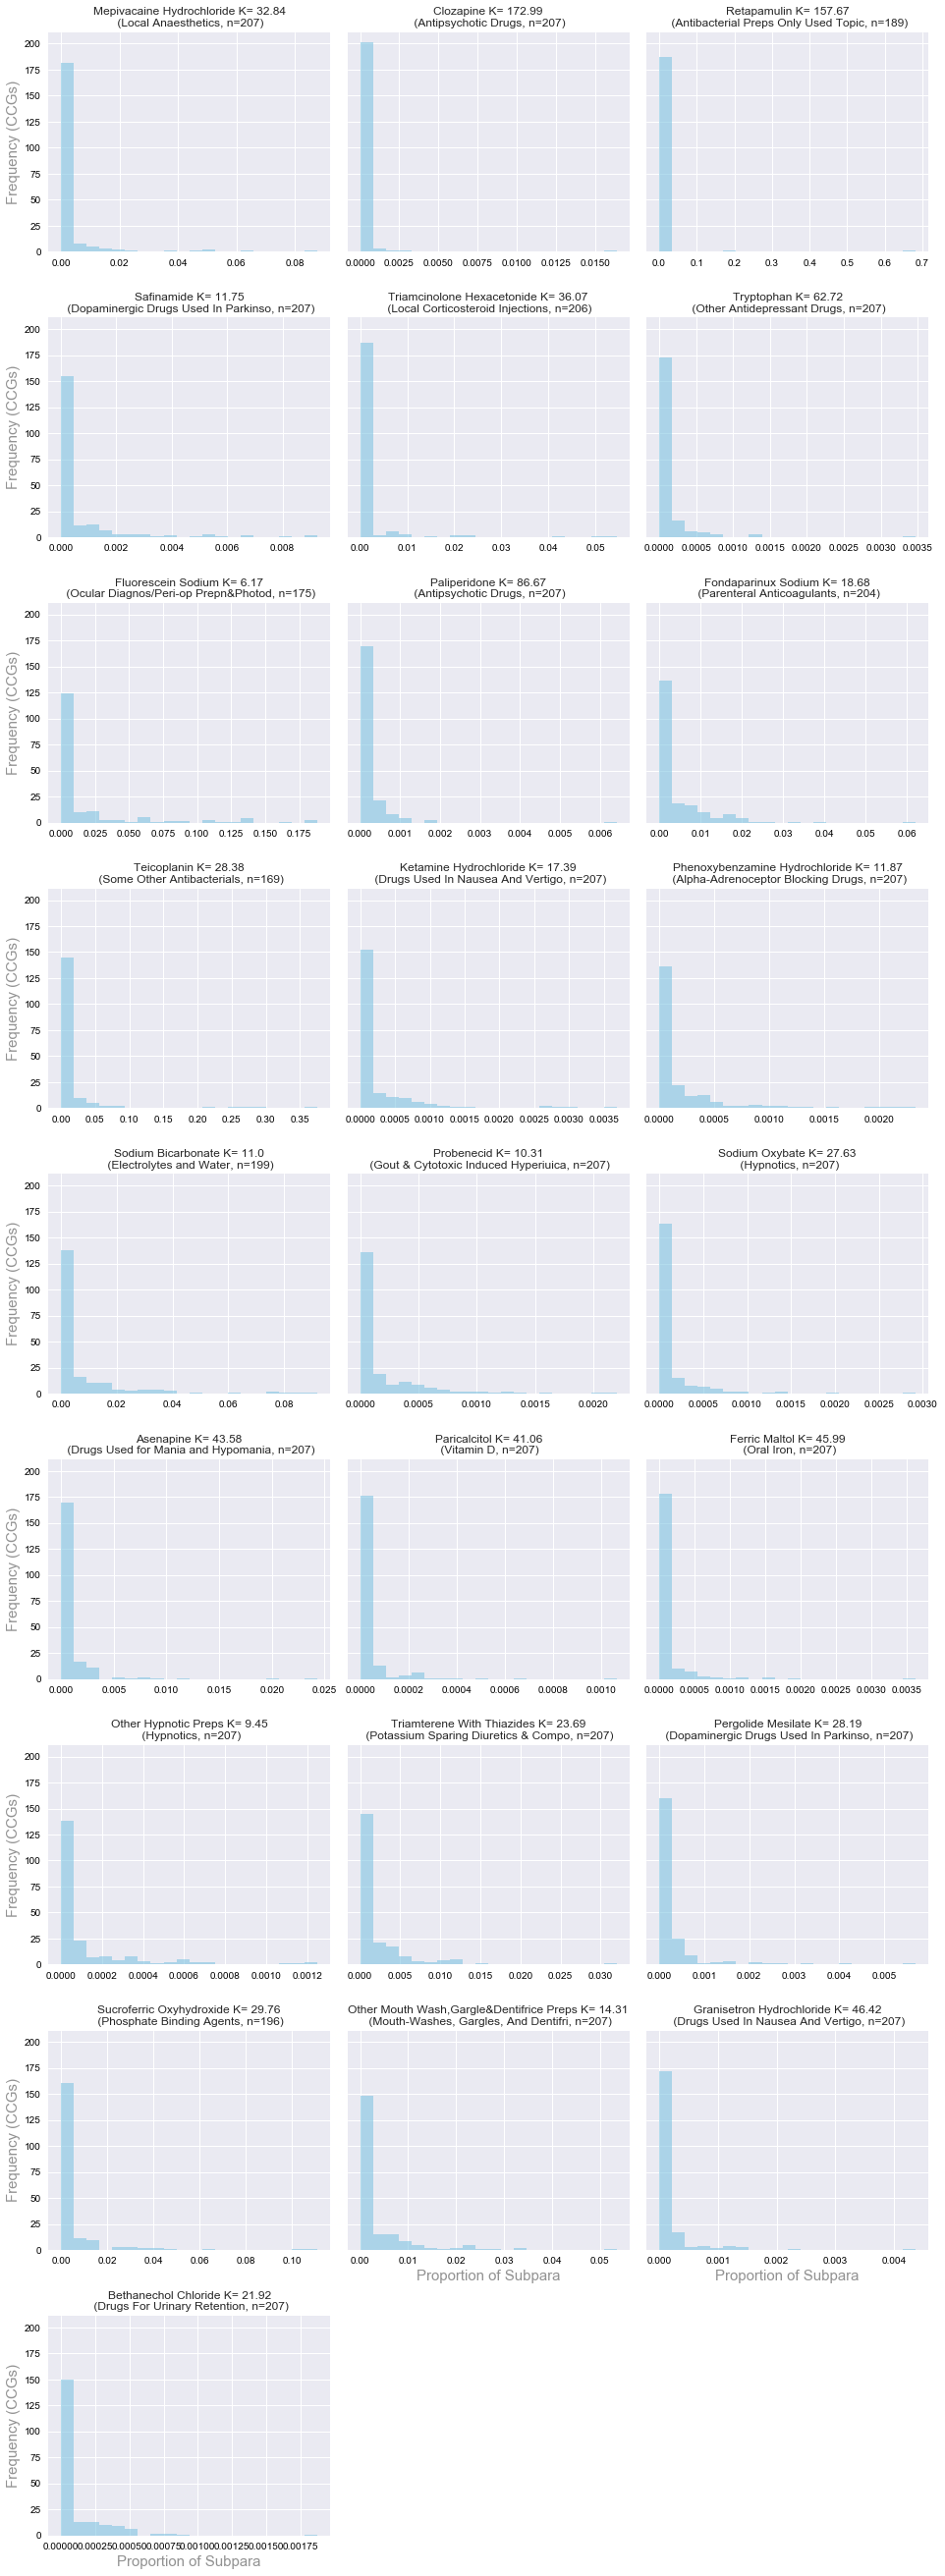

In [30]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy6.sort_values(by="M6",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis"]].merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Compile results

In [49]:
sc = pd.merge(rc, smy[["chemical","kurtosis","range","M1"]], on=["chemical","kurtosis","range"], how="outer")
sc = pd.merge(sc, smy2[["chemical","kurtosis","range","M2"]], on=["chemical","kurtosis","range"], how="outer")#, smy2, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
#sc = pd.merge(sc, smy3, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy4[["chemical","kurtosis","range","M4"]], on=["chemical","kurtosis","range"], how="outer")#, smy4, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy5b[["chemical","kurtosis","range","M5"]], on=["chemical","kurtosis","range"], how="outer")#, smy5b, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")
sc = pd.merge(sc, smy6[["chemical","kurtosis","range","M6"]], on=["chemical","kurtosis","range"], how="outer")#, smy6, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","median","min","max","range", "std","kurtosis","skew"], how="outer")

sc = sc.fillna(0)
sc = df4.merge(sc, on=["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"])
sc["score"] = sc["score"]+sc["M1"]+sc["M2"]+sc["M4"]+sc["M5"]+sc["M6"]
sc = sc.sort_values(by=["score","kurtosis","range"],ascending=False)

links = sc.head(50)
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)
#https://openprescribing.net/analyse/#org=CCG&numIds=100302010&denomIds=10.3.2&selectedTab=map
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links


C:\Users\hcurtis\Anaconda2\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\hcurtis\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


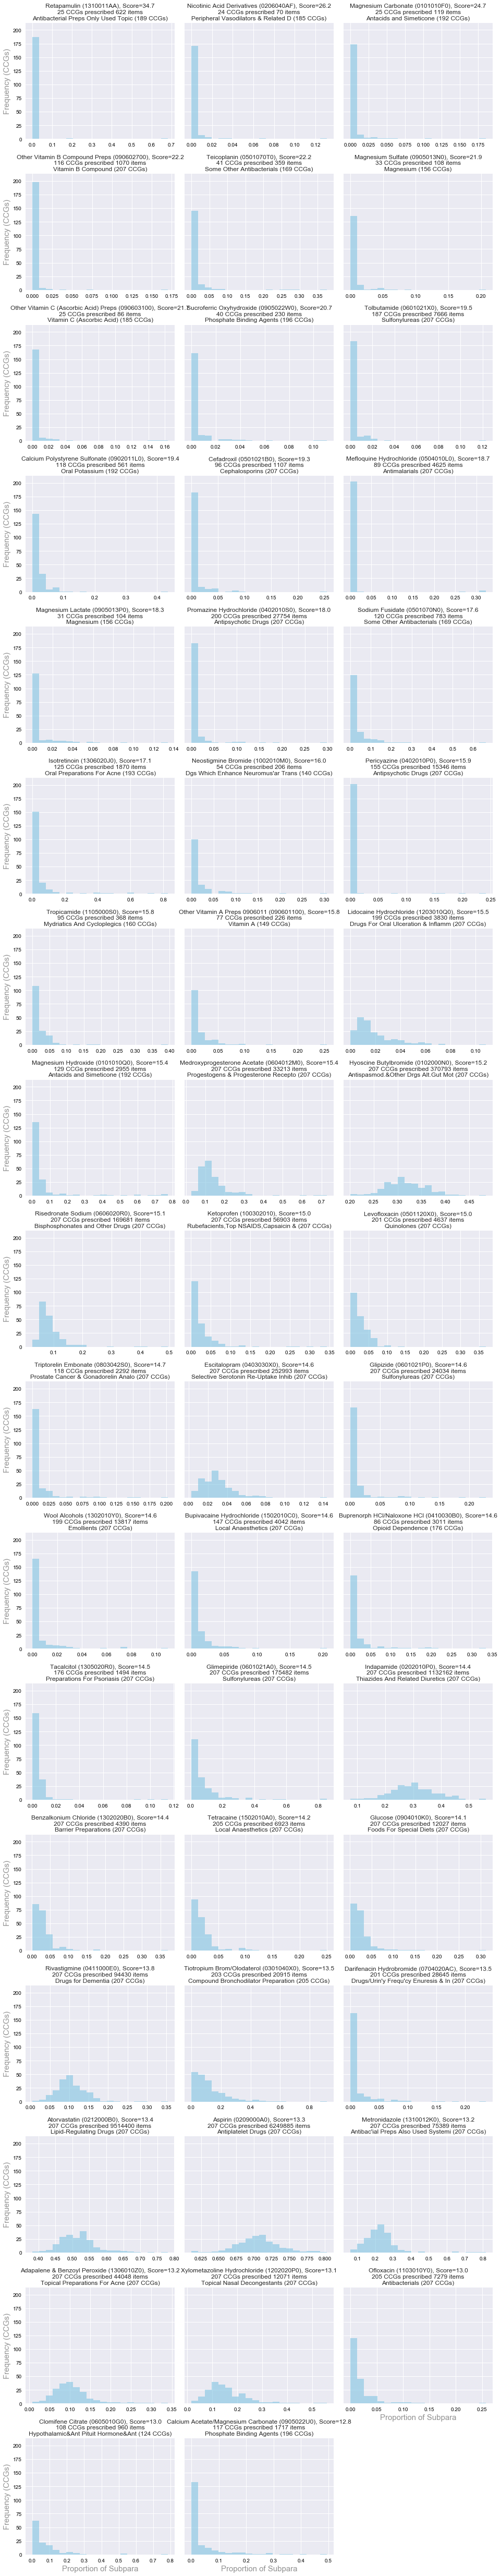

In [80]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = sc.head(50)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","score","count","count2","num_total"]].merge(data3[["chemical","ratio"]], on="chemical")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical","chemical name","subpara name","kurtosis","score","count","count2","num_total"]).count().reset_index().rename(columns={"ratio":"n"})
#titles["title"] = titles["chemical name"]+" K= "+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")\n Score "+titles["score"].round(1).map(str)
titles["title"] = titles["chemical name"]+" ("+titles["chemical"]+"), Score="+titles["score"].round(1).map(str)+"\n"+titles["count2"].map(int).map(str)+" CCGs prescribed "+titles["num_total"].map(int).map(str)+" items\n"+titles["subpara name"].str[0:35]+" ("+titles["count"].map(int).map(str)+" CCGs)"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Paragraph Rankings
Which paragraphs occur most often in the list of interesting chemicals?

In [83]:
sc.groupby(["subpara","subpara name"])["score"].agg(["count","sum"]).sort_values(by=["count","sum"],ascending=False).head(20)


count         sum
subpara subpara name                                               
0101010 Antacids and Simeticone                      10  111.388051
0601023 Other Antidiabetic Drugs                     10   74.851755
1106000 Treatment Of Glaucoma                         8   51.300860
0402020 Antipsychotic Depot Injections                7   62.848173
0803042 Prostate Cancer & Gonadorelin Analogues       7   60.646028
0601012 Intermediate And Long-Acting Insulins         7   51.229254
0905013 Magnesium                                     6   73.367030
1003020 Rubefacients,Top NSAIDS,Capsaicin & Poul      6   53.367179
1108020 Ocular Diagnos/Peri-op Prepn&Photodyn Tt      6   50.454451
0304010 Antihistamines                                6   40.714741
0704020 Drugs/Urin'y Frequ'cy Enuresis & Incont       6   38.353814
0409010 Dopaminergic Drugs Used In Parkinsonism       6   37.740960
0206040 Peripheral Vasodilators & Related Drugs       5   66.838269
0501070 Some Other Antibacterials                     5   58.838772
0407041 Treatment Of Acute Migraine                   5   45.262906
1306010 Topical Preparations For Acne                 5   44.943826
1201010 Otitis Externa                                5   41.269773
0105020 Corticosteroids                               5   40.647085
1104010 Corticosteroids                               5   33.404232
0407020 Opioid Analgesics                             5   32.221889

## CCG Rankings
### Ranking CCGs for the list of interesting chems only, by Distance from Median

In [84]:
dftest = sc[["chemical","chemical name","subpara name","min","max","range","median"]].merge(data3, on="chemical")
#dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
dftest["abs diff"] = abs(dftest["ratio"]-dftest["median"])/dftest["range"]
dftest["rank abs diff"] = dftest.groupby(["chemical"])["abs diff"].rank(pct=True)
dftest.sort_values(by=["chemical","rank abs diff"])

#x0 = dftest.loc[(dftest["rank abs diff"]<=0.05)]# & (dftest["median"]>0)]
x1 = dftest.loc[(dftest["rank abs diff"]>=0.95)]# & (dftest["median"]<1)] 
x2 = x1#x0.append(x1)
x2 = x2.groupby("pct")["abs diff"].agg(["count","mean"])
x2.sort_values(by=["count","mean"],ascending=False).head(12)



count      mean
pct                 
02W     61  0.504163
00N     41  0.531497
03H     41  0.456903
99C     40  0.505684
02R     39  0.512403
08V     39  0.479161
06V     38  0.471082
13T     34  0.543576
00L     34  0.517695
10T     34  0.500178
03Y     33  0.514793
00P     33  0.503007

### Investigate example CCG

In [85]:
x3 = x1[["pct","chemical"]].merge(dftest, how="inner", on=["pct","chemical"]).drop(["subpara","denom","range"], axis=1)
x3.loc[x3["pct"]=="02W"].sort_values(by=["rank abs diff","abs diff"],ascending=False)

pct   chemical                             chemical name  \
180   02W  1105000S0                               Tropicamide   
1530  02W  0601012F0                   Biphasic Insulin Lispro   
1602  02W  0205020E0                   Clonidine Hydrochloride   
1780  02W  0404000S0                 Atomoxetine Hydrochloride   
1329  02W  0407041A0              Analgesics with Anti-Emetics   
3044  02W  0206030Y0                                Ivabradine   
2491  02W  130801000                  Other Sunscreening Preps   
2542  02W  040702040                    Tramadol Hydrochloride   
1413  02W  0906050T0                        Tocopheryl Acetate   
3383  02W  0802010G0                              Azathioprine   
3430  02W  0203020D0                  Amiodarone Hydrochloride   
351   02W  0601021A0                               Glimepiride   
2165  02W  0704020Z0                         Trospium Chloride   
337   02W  1305020R0                                Tacalcitol   
243   02W  0606020R0                        Risedronate Sodium   
2617  02W  0208020Y0                               Rivaroxaban   
437   02W  0212000B0                              Atorvastatin   
1544  02W  1202020L0                           Sodium Chloride   
3118  02W  0411000G0                   Memantine Hydrochloride   
33    02W  090602700            Other Vitamin B Compound Preps   
220   02W  0604012M0               Medroxyprogesterone Acetate   
808   02W  0103050R0                              Pantoprazole   
1461  02W  0601023B0                Pioglitazone Hydrochloride   
4018  02W  0803041B0                               Anastrozole   
1843  02W  0106020P0                        Sodium Picosulfate   
2708  02W  1202020I0                       Ipratropium Bromide   
2646  02W  131002030                 Terbinafine Hydrochloride   
735   02W  0411000D0                   Donepezil Hydrochloride   
1022  02W  0607010T0                 Quinagolide Hydrochloride   
3062  02W  1105000E0              Cyclopentolate Hydrochloride   
...   ...        ...                                       ...   
679   02W  0901011H0                         Ferrous Gluconate   
2763  02W  0501050H0               Erythromycin Ethylsuccinate   
1713  02W  1001030C0                Hydroxychloroquine Sulfate   
1707  02W  1304000V0                            Hydrocortisone   
3683  02W  0403040W0                               Venlafaxine   
331   02W  0410030B0               Buprenorph HCl/Naloxone HCl   
1162  02W  0501021M0                                 Cefradine   
2191  02W  1308010W0                         Diclofenac Sodium   
1142  02W  0202040C0  Co-Amilozide (Amiloride HCl/Hydchloroth)   
534   02W  0304010J0                 Hydroxyzine Hydrochloride   
3550  02W  1303000D0                                  Calamine   
4183  02W  0404000U0               Lisdexamfetamine Dimesylate   
2247  02W  0501120P0                                 Ofloxacin   
2775  02W  1304000Y0                        Mometasone Furoate   
456   02W  1310012K0                             Metronidazole   
3234  02W  0103050L0                              Lansoprazole   
3349  02W  0402030Q0                             Valproic Acid   
1671  02W  0601011L0                            Insulin Lispro   
3977  02W  0502010C0                              Itraconazole   
1949  02W  0411000F0                               Galantamine   
4154  02W  0703050B0       Ulipristal Acetate (Emergency Cont)   
2839  02W  1106000AI                     Timolol & Bimatoprost   
909   02W  0601012V0                          Insulin Glargine   
2880  02W  0409010N0         Co-Careldopa (Carbidopa/Levodopa)   
3631  02W  140400070                   Hepatitis A/Hepatitis B   
3595  02W  0304010G0                    Chlorphenamine Maleate   
1096  02W  1306010F0                     Clindamycin Phosphate   
369   02W  1302020B0                     Benzalkonium Chloride   
3781  02W  1308010Y0                  Fluorour

## 99P

In [86]:
dftest.loc[dftest["pct"]=="99P"].sort_values(by=["rank abs diff"],ascending=False).head(12)

chemical                            chemical name  \
58166  0106040M0                            Macrogol 3350   
4944   0501120X0                             Levofloxacin   
42790  1201010F0                     Flumetasone Pivalate   
78095  120101040  Dexamethasone Sodium Metasulphobenzoate   
65591  0205052C0                    Candesartan Cilexetil   
51504  0601012S0                         Isophane Insulin   
27230  1308010Z0                         Ingenol Mebutate   
24435  0902012L0                          Sodium Chloride   
16533  0702020X0                            Metronidazole   
5151   0803042S0                     Triptorelin Embonate   
24843  0105020G0    Beclometasone Dipropionate (Systemic)   
4530   0606020R0                       Risedronate Sodium   

                                  subpara name   min   max  range  median  \
58166                        Osmotic Laxatives  0.49  0.82   0.33    0.65   
4944                                Quinolones  0.00  0.37   0.37    0.02   
42790                           Otitis Externa  0.01  0.13   0.12    0.03   
78095                           Otitis Externa  0.01  0.13   0.12    0.05   
65591      Angiotensin-II Receptor Antagonists  0.08  0.76   0.68    0.30   
51504    Intermediate And Long-Acting Insulins  0.01  0.42   0.41    0.11   
27230                Sunscreening Preparations  0.00  0.31   0.31    0.02   
24435                    Oral Sodium And Water  0.01  0.80   0.79    0.25   
16533            Vaginal and Vulval Infections  0.01  0.11   0.11    0.03   
5151   Prostate Cancer & Gonadorelin Analogues  0.00  0.20   0.20    0.00   
24843                          Corticosteroids  0.00  0.19   0.19    0.00   
4530           Bisphosphonates and Other Drugs  0.03  0.49   0.47    0.08   

       pct  subpara  denom_subpara      num    denom     ratio  num_total  \
58166  99P  0106040        36953.0  30337.0  36953.0  0.820962    1530949   
4944   99P  0501120         2136.0    788.0   2136.0  0.368914       4637   
42790  99P  1201010         6372.0    618.0   6372.0  0.096987      12991   
78095  99P  1201010         6372.0    716.0   6372.0  0.112367      23142   
65591  99P  0205052        93647.0  62973.0  93647.0  0.672451    1707230   
51504  99P  0601012        19590.0   7588.0  19590.0  0.387340     159256   
27230  99P  1308010         3353.0    811.0   3353.0  0.241873       6222   
24435  99P  0902012         1531.0    763.0   1531.0  0.498367      22483   
16533  99P  0702020         3580.0    266.0   3580.0  0.074302       8271   
5151   99P  0803042         3542.0    332.0   3542.0  0.093732       2292   
24843  99P  0105020          539.0     66.0    539.0  0.122449        719   
4530   99P  0606020        40839.0   7025.0  40839.0  0.172017     169681   

       num centile  denom_subpara_total  denom centile  count2  abs diff  \
58166           10            2348113.0              9     207  0.518066   
4944             6             152912.0              6     201  0.943010   
42790            7             452610.0              7     207  0.558223   
78095            7             452610.0              7     207  0.519722   
65591           10            5073991.0             10     207  0.547722   
51504            9            1231970.0              8     207  0.676440   
27230            6             114629.0              5     192  0.715719   
24435            7             100069.0              5     207  0.314389   
16533            6             255492.0              6     207  0.402743   
5151             5             196610.0              6     118  0.468662   
24843            4              28411.0              4      97  0.644468   
4530             9            1856931.0              9     207  0.195781   

       rank abs diff  
58166       1.000000  
4944        1.000000  
42790       0.995169  
78095       0.990338  
65591       0.990338  
51504       0.990338  
27230       0.990338  
24435       0.980676  
16533       0.

- charts x
- better ccg ranking x
- create table of links x
- change the query so it only limits by subpara >n rather than chemical x
- practice level
- better chemical ranking (logs?)


## Other ways of ranking CCGs / finding odd prescribing
### CCGs ranked in top or bottom 5% for prescribing any chemical

In [9]:
dftest = data3#.head(1000)
dftest

dftest["rank"] = dftest.groupby(["chemical"])["ratio"].rank(pct=True)
#dftest.groupby(["pct"])["ratio"].sum()
#dftest.loc[dftest["chemical"]=="0101010C0"].sort_values(by=["chemical","rank"])

x = dftest.loc[(dftest["rank"]<=0.05) | (dftest["rank"]>=0.95)]
x2 = x.groupby("pct")["rank"].count()
print x2.sort_values(ascending=False).head(10)
print x2.sort_values().head(10)

pct
02W    263
03V    202
08V    190
99C    182
10T    182
03Y    177
07T    168
00N    164
03X    164
03H    161
Name: rank, dtype: int64
pct
06N    50
99H    51
06K    54
09Y    54
07H    55
09G    56
99N    56
06H    58
13P    58
06F    59
Name: rank, dtype: int64
